| <p style="text-align: left;">Name</p>               | Matr.Nr. | <p style="text-align: right;">Date</p> |
| --------------------------------------------------- | -------- | ------------------------------------- |
| <p style="text-align: left">Lion DUNGL</p> | 01553060 | 18.01.2020                            |

<h1 style="color:rgb(0,120,170)">Hands-on AI I</h1>
<h2 style="color:rgb(0,120,170)">Unit 6 (Assignment) -- Generative models </h2>

Authors: Brandstetter, Schäfl<br>
Date: 02-01-2020

This file is part of the "Hands-on AI I" lecture material. The following copyright statement applies 
to all code within this file.

Copyright statement: <br>
This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

# Exercise 0
Before tackling all those exciting tasks of this notebook, the neccessary Python modules need to be loaded. Have a look at the notebook discussed during the lecture, and import the following modules/symbols:

- <code>u6_utils</code>
- <code>matplotlib.pyplot</code>
- <code>matplotlib.image</code>
- <code>numpy</code>
- <code>os</code>
- <code>torch</code>
- <code>torch.autograd.Variable</code>
- <code>types.SimpleNamespace</code>

In [1]:
import u6_utils as u6
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import torch
from torch.autograd import Variable
from types import SimpleNamespace

Afterwards, check if the <code>torch</code> module was correctly imported, by computing the <i>cumsum</i> of <code>[7, 2, 4, 9]</code> and printing the result. Moreover, check the version of your <i>PyTorch</i> installation (in case of problems with different Python modules, it is <i>always</i> a good idea to include their <i>version numbers</i> to help others giving a more specific support).

In [2]:
torch.cumsum(torch.as_tensor([7, 2, 4, 9], dtype=torch.float32), dim=0)

tensor([ 7.,  9., 13., 22.])

In [3]:
torch.__version__

'1.3.1'

As all plots <i>created</i> in this assignment are <i>stored</i> in a specific <i>directory</i>, create a <i>subdirectory</i> termed <code>samples</code> in the current working directory.

In [4]:
if not os.path.exists(os.path.join(r'.', r'samples')):
    os.makedirs(os.path.join(r'.', r'samples'))

# Exercise 1
Before loading any <i>data set</i> or defining any <i>neural network</i>, some hyperparameters used throughout this assignment should be set (some entries might be <i>reset</i> in the course of some tasks). Hence, for the <b>first task</b> of this exercise, define an <i>instance</i> of the type <code>SimpleNamespace</code>, and set the hyperparameters accordingly:

- <code>batch_size = 64</code>
- <code>test_batch_size = 1000</code>
- <code>epochs = 10</code>
- <code>lr = 0.001</code>
- <code>weight_decay = 0.00005</code>

The field <code>log_interval</code> can be chosen freely as well as the <i>device</i> on which to compute.

In [5]:
args = SimpleNamespace(batch_size=64, test_batch_size=1000, epochs=10, lr=0.001, 
                       weight_decay=0.00005, log_interval=100)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In this exercise you will be working with a data set composed of various <i>images</i> of fashion items. For curious minds, more information regarding this data set can be found at (maybe it looks already familiar to you):

<cite>Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf. arXiv:1708.07747</cite>

Moreover, perform the following steps prior to unleashing your cumulated knowledge about <i>machine learning</i> on the data:

- Set the <i>random seed</i> to $s = 42$ using the <i>PyTorch</i> interface.
- Load the <i>Fashion-MNIST</i> data set (returns the <i>training</i> as well as the <i>test</i> set data loader).
- Display the first <i>36</i> images of the <i>Fashion-MNIST</i> data set.

Can you identify possible <i>labels</i> of the displayed images?

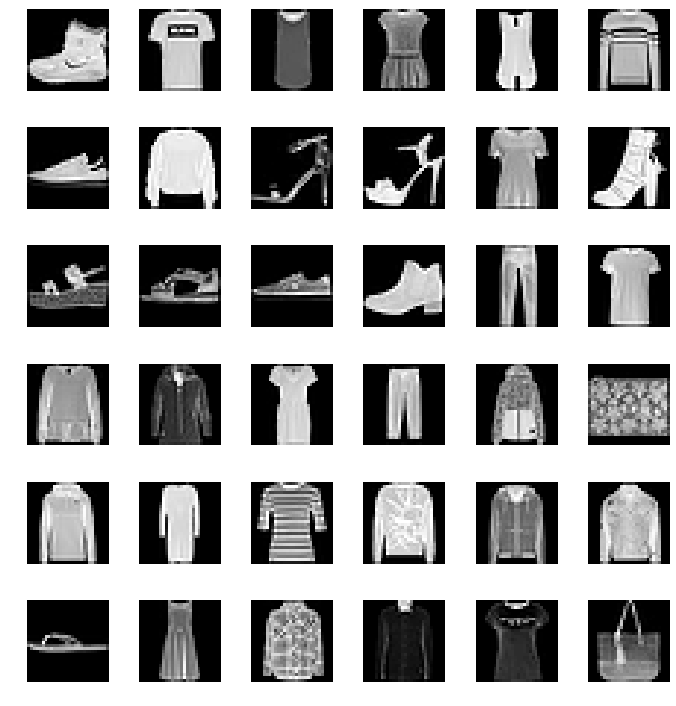

In [6]:
torch.manual_seed(42)
train_loader, test_loader = u6.get_FashionMNIST_data(args, use_cuda)
u6.display_FashionMNIST(train_loader, images_to_show=36)

# Answer
## Possible labels
- shoe (images 1, 7, 9, 10, 12, 13, 14, 15, 16, 31)
- pants (images 17, 22)
- dress (images 3, 4, 5, 11, 21, 26, 32)
- shirt (images 2, 6, 18, 24, 27, 28, 33, 35)
- sweater (images 8, 19, 20, 23, 25, 29, 34)
- other (30, 36)

--> target tensor would look something like this: tensor([0, 3, 2, 2, 2, 3, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 1, 3, 4, 4, 2, 1, 4, 3, 4, 2, 3, 3, 4, 5, 0, 2, 3, 4, 3, 5])

In [7]:
print("Real target tensor:", train_loader.dataset.targets[:36])

Real target tensor: tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8,
        4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8])


# Real labels
## in general
- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot 

In order to define any <i>generative</i> neural network (e.g. <i>autoencoders</i> and their various variants) for further processing of the data set, some minimal knowledge about the <i>structure</i> of the images is required:

- Find out the <i>input dimensionality</i> of the data set.

Moreover, with respect to possible transitions between labels in a hypothetical <i>latent space</i>, are some targets <i>more</i> suited to be transitioned into each other than others? Try to argue about <i>possible</i> reasons.

In [8]:
input_dim = train_loader.dataset.data.shape[1]*train_loader.dataset.data.shape[2]
print("The input dimensionality is", input_dim)

The input dimensionality is 784


# Answer
In my opinion, targets of fashion items that look in some way similar are most suited to be transitioned into each other. E.g. a fashion item with the label dress and one with the label sweater are more suited than some with the labels shoe and shirt. 

When transitioning a dress into a sweater, it is possible that during the walk in the latent space, "artificial" images of fashion items with e.g. the label shirt are occuring during the process.

This is less likely to happen when transitioning an image with the label shoe to one with the label shirt. Here, the possibility is very high that during the walk in latent space only meaningless images are arising.

As <i>autoencoders</i> (and their variants) are very handy tools for <i>projecting</i> data sets <i>down</i> to a specific dimensionality (often termed <i>compression</i>), a comparison to other established methods is appropriate. For this very purpose, recall your knowledge about <i>dimensionality reduction techniques</i> and perform the following steps as your <b>second task</b> of this exercise:

- Apply <i>PCA</i> on the first $n = 1000$ entries and project the Fashion-MNIST data set down to <i>two</i> components.
- Display the resulting data in a colored <i>scatter plot</i>.

Hint: both steps can be performed at <i>once</i> (look at the notebook presented during the lecture or the accompanying <code>u6_utils.py</code> file).

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

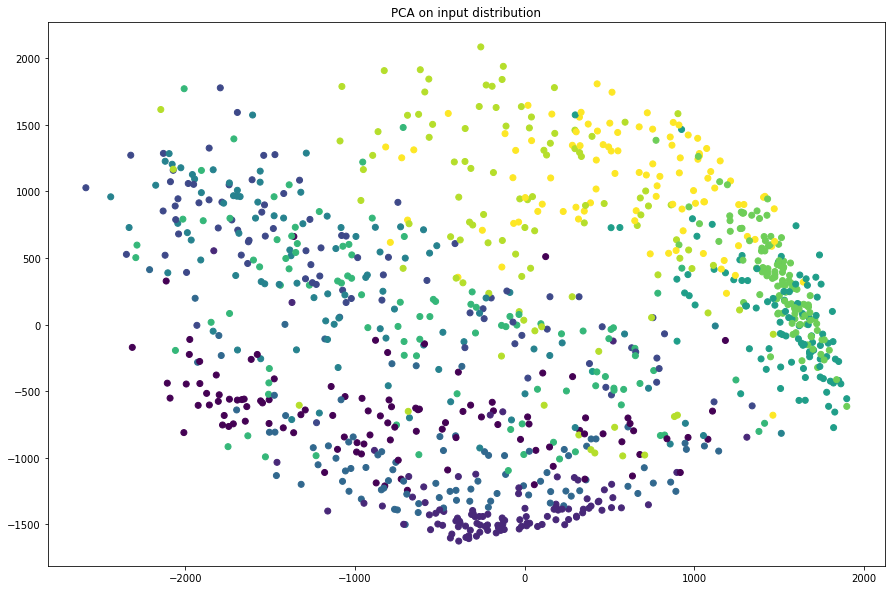

In [9]:
u6.plot_PCA(train_loader, 'PCA on input distribution', 1000)

# AttributeError is also occuring in my lesson-notebook. Since the plot seems to be correct and the error
# just seems to be regarding the plotting, I didn't try to get rid of it.

Repeat the <i>principal component analysis</i>, while considering only the following <i>targets/classes</i>:

- $c = (0, 7, 8)$

Is the result of the <i>PCA</i> applied on only those <i>three</i> classes more distinctive compared to the previous plot (which considered <i>all</i> classes)? Experiment with different <i>targets</i>, which are $\ldots$

- $\ldots$ <i>similar</i> to each other.
- $\ldots$ <i>different</i> to each other.

How does PCA work on them?

# labels
- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

-->

- similar labels: e.g. (0, 2, 3), (5, 7, 9),...
- different labels: e.g. (3, 5, 8), (1, 2, 7),...

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

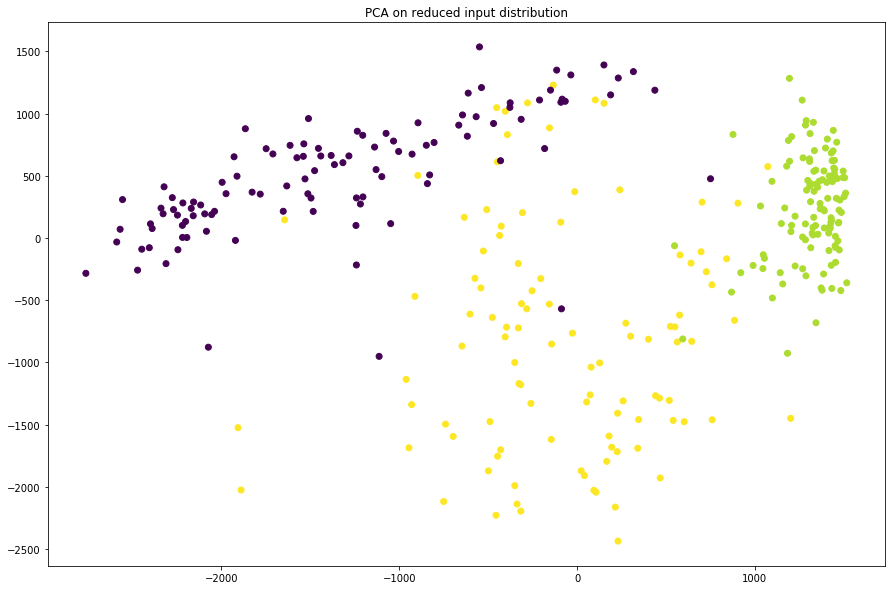

In [10]:
u6.plot_PCA_reduced(train_loader, 'PCA on reduced input distribution', 1000, [0, 7, 8])

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

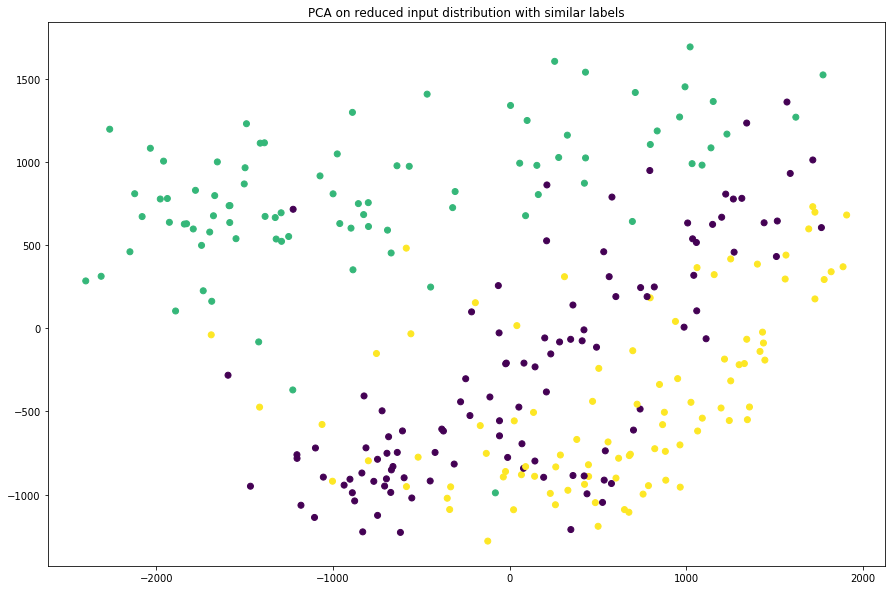

In [11]:
u6.plot_PCA_reduced(train_loader, 'PCA on reduced input distribution with similar labels', 1000, [0, 2, 3])

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

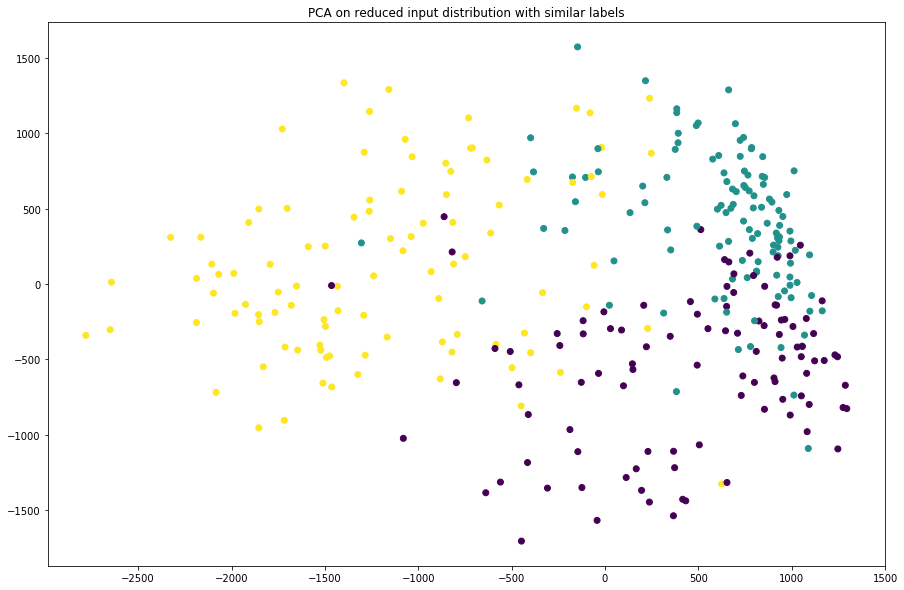

In [12]:
u6.plot_PCA_reduced(train_loader, 'PCA on reduced input distribution with similar labels', 1000, [5, 7, 9])

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

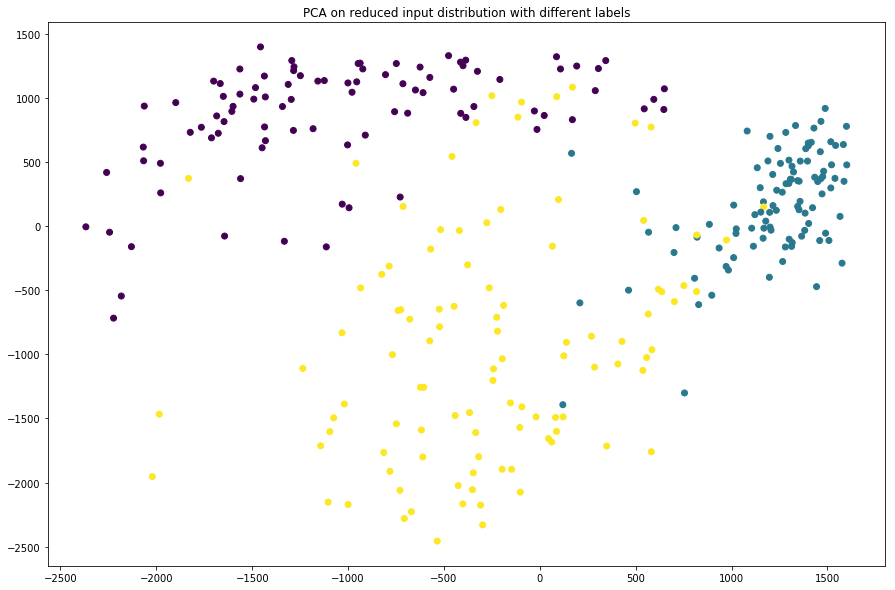

In [13]:
u6.plot_PCA_reduced(train_loader, 'PCA on reduced input distribution with different labels', 1000, [3, 5, 8])

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

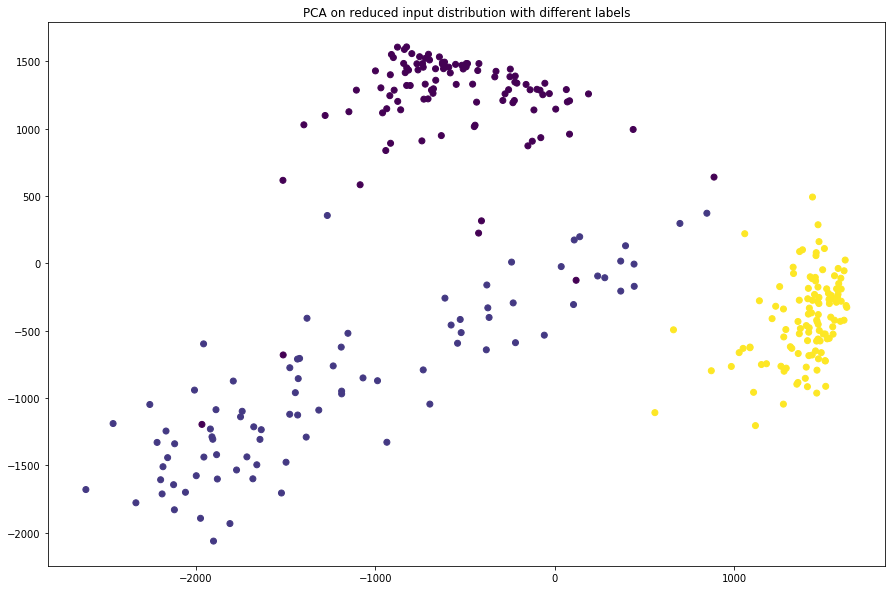

In [14]:
u6.plot_PCA_reduced(train_loader, 'PCA on reduced input distribution with different labels', 1000, [1, 2, 7])

# Answer
## Difference between normal PCA and PCA reduced
In general the targets can be better distinguished when using only a few than all.

## Difference between plots with different targets using PCA reduced
Different clusters are much better visible when using three labels that are not very similar (e.g. dress, sandal, bag). When using targets that are very similar to each other (e.g. T-shirt, pullover, dress) the different cluster are much more mixed up.

<i>Principal component analysis</i> is not the only dimensionality reduction technique presented in this course, so to extend the <b>second task</b> of this exercise, further recall your knowledge about this topic (or have a glimpse at the notebooks of the lecture) and perform the following steps:

- Set the <i>random seed</i> to $s = 42$ using the <i>numpy</i> interface.
- Apply <i>t-SNE</i> on the first $n = 1000$ entries and project the Fashion-MNIST data set down to <i>two</i> components.
- Display the resulting data in a colored <i>scatter plot</i>.

Hint: the latter two steps can be performed at <i>once</i> (look at the notebook presented during the lecture or the accompanying <code>u6_utils.py</code> file).

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

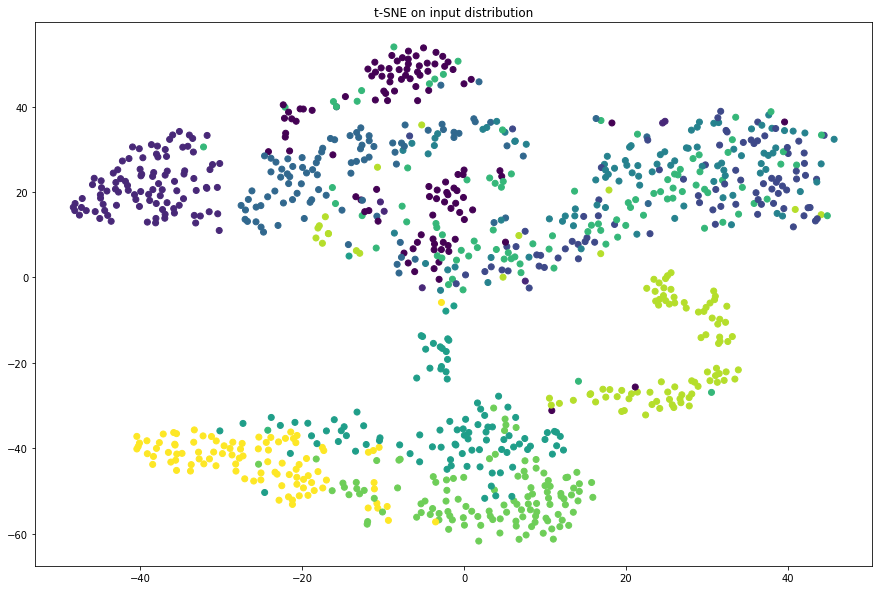

In [15]:
np.random.seed(42)
u6.plot_tsne(train_loader, 't-SNE on input distribution', 1000)

Repeat the <i>t-distributed stochastic neighbor embedding</i> approach, while considering only the following <i>targets/classes</i>:

- $c = (0, 7, 8)$


Keep in mind to <i>reset</i> the seed as described above!

Is the result of <i>t-SNE</i> applied on only those <i>three</i> classes more distinctive compared to the previous plot (which considered <i>all</i> classes)? Experiment with different <i>targets</i>, which are $\ldots$

- $\ldots$ <i>similar</i> to each other.
- $\ldots$ <i>different</i> to each other.

How does t-SNE work on them? Compare your results with the respective counterparts of the PCA projection.

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

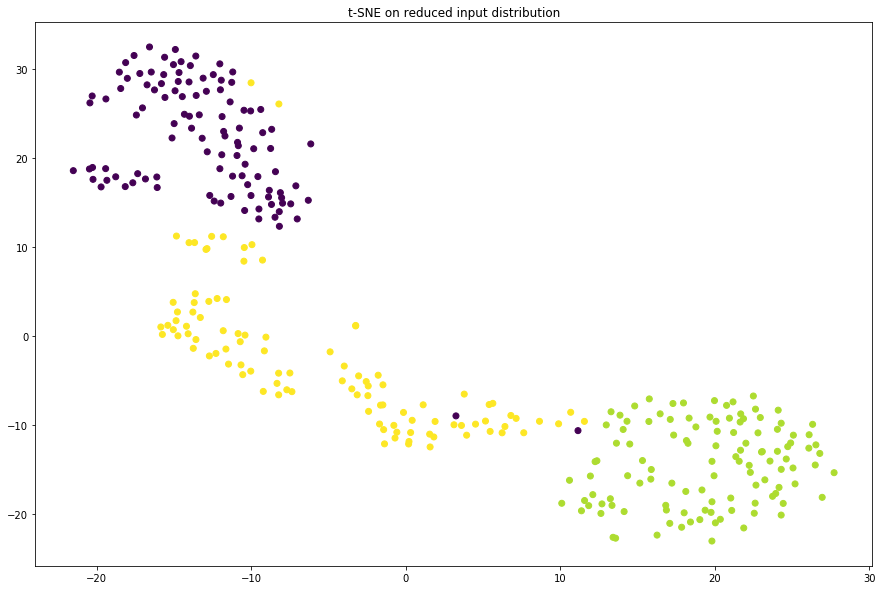

In [16]:
u6.plot_tsne_reduced(train_loader, 't-SNE on reduced input distribution', 1000, [0, 7, 8])

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

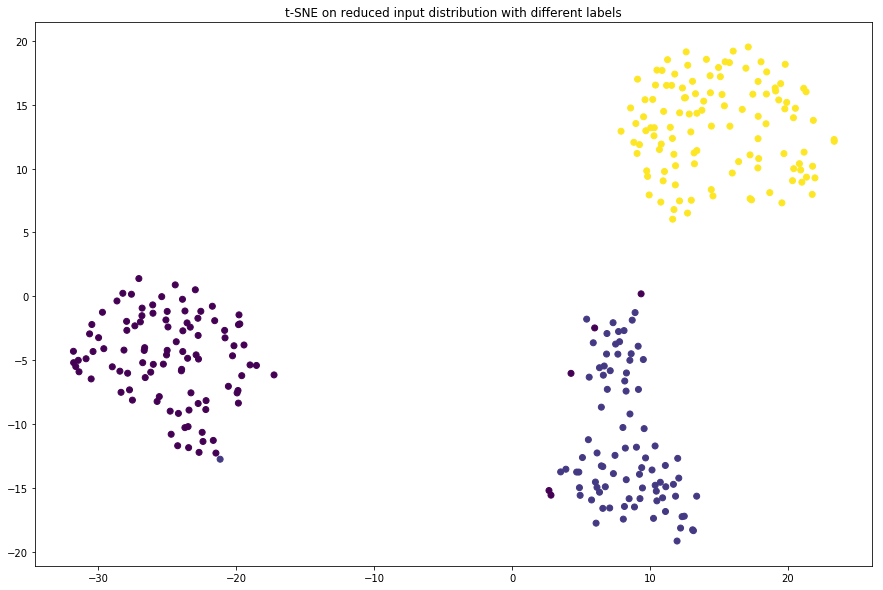

In [17]:
u6.plot_tsne_reduced(train_loader, 't-SNE on reduced input distribution with different labels', 1000, [1, 2, 7])

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

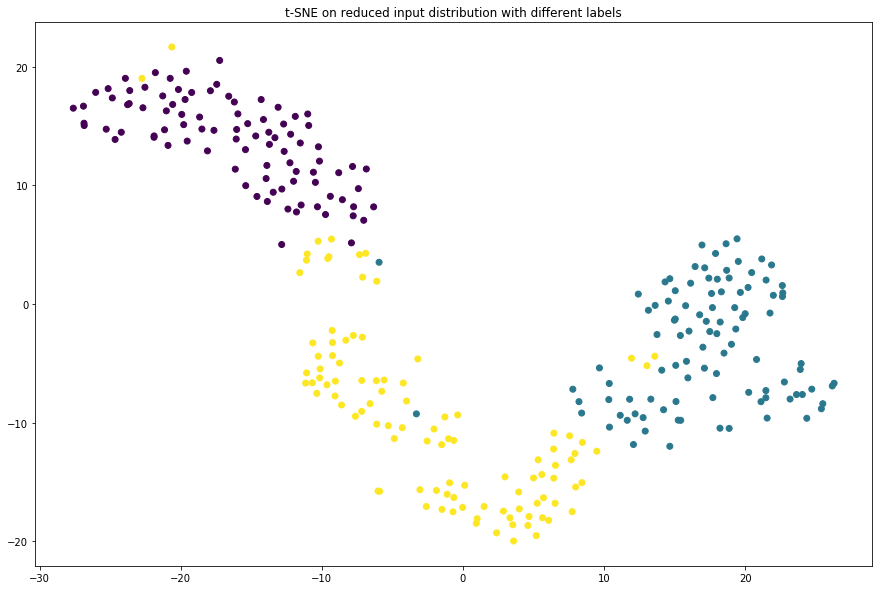

In [18]:
u6.plot_tsne_reduced(train_loader, 't-SNE on reduced input distribution with different labels', 1000, [3, 5, 8])

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

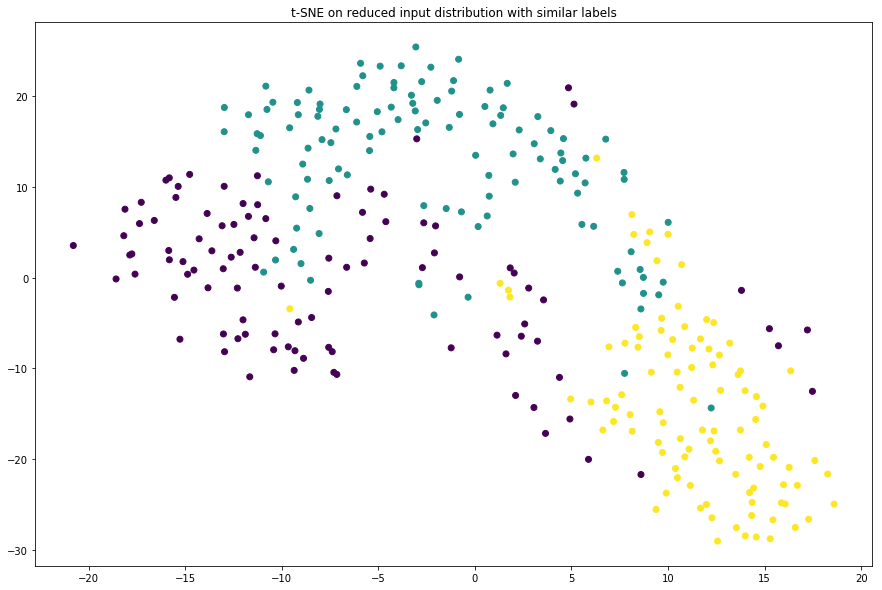

In [19]:
u6.plot_tsne_reduced(train_loader, 't-SNE on reduced input distribution with similar labels', 1000, [5, 7, 9])

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

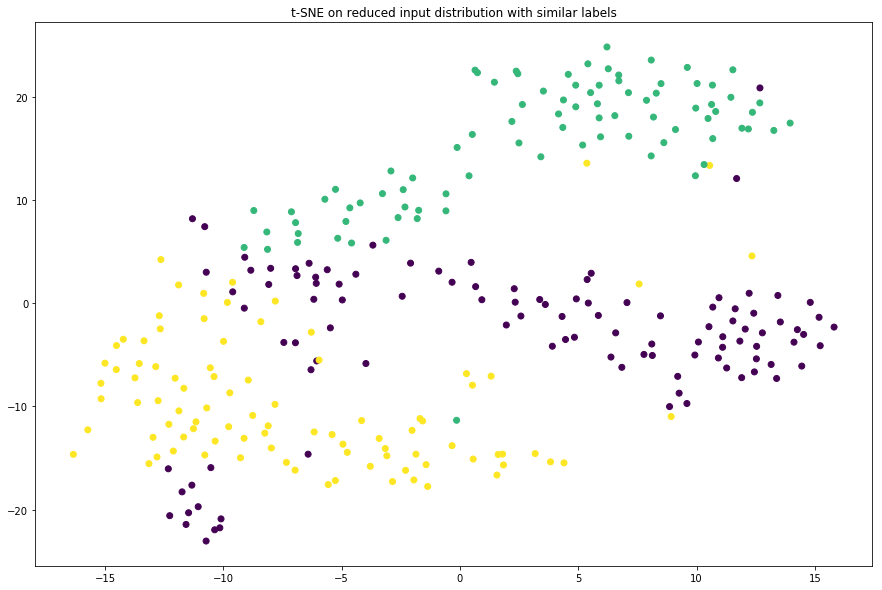

In [20]:
u6.plot_tsne_reduced(train_loader, 't-SNE on reduced input distribution with similar labels', 1000, [0, 2, 3])

# Answer
## Difference between normal t-SNE and t-SNE reduced
In general the targets can be better distinguished when using only a few than all.

## Difference between plots with different targets using t-SNE reduced
Different clusters are much better visible when using three labels that are not very similar (e.g. dress, sandal, bag). When using targets that are very similar to each other (e.g. T-shirt, pullover, dress) the different cluster are much more mixed up.

## Difference between PCA and t-SNE
In general, the clusters are better visible using t-SNE than using PCA. Even when using similar targets, t-SNE provides acceptable results wheras this is not always the case with the PCA. E.g. with the targets shirt, pullover, dress using the PCA all the clusters are more or less mixed up. Using t-SNE those clusters are visible.

# Exercise 2
After recalling <i>two</i> most famous dimensionality reduction techniques

- principal component analysis (PCA)
- t-distributed stochastic neighbor embedding (t-SNE)

we want to investigate a third method, this time based on <i>neural networks</i> (which enables us a more fine-grained control over the <i>compression</i> phase). Moreover, as the family of the models of interest are of a <i>generative</i> nature, we can actually utilize them to <i>generate</i> new (related) samples. To get you started, the <b>first task</b> of this exercise requires you to perform the following steps:

- Set the dimensionality of the latent space to be $d_{h} = 10$.
- Define an <code>autoencoder</code> instance (supplied by <code>u6_utils.py</code>) using previously defined input dimensionality $d_{in}$.
- Define an <code>Adam</code> instance using previously defined <i>hyperparameters</i>.

Train the newly defined <i>autoencoder</i> model by applying the corresponding <i>data loader</i> (keep in mind for which set we want the model to be <i>trained</i>) as well as the <i>optimizer</i>. Experiment with <i>different</i> values for $d_{h}$ and report their performances on the <i>test set</i> afterwards.

In [21]:
hidden_dim_0 = 10

model = u6.autoencoder(input_dim, hidden_dim_0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

In [22]:
for epoch in range(1, args.epochs + 1):
    u6.train_autoencoder(args, model, device, train_loader, input_dim, optimizer, epoch)
    u6.test_autoencoder(args, model, device, test_loader, input_dim)

Train Epoch: 01 [6400/60000 (11%)]	Loss: 0.349570
Train Epoch: 01 [12800/60000 (21%)]	Loss: 0.337896
Train Epoch: 01 [19200/60000 (32%)]	Loss: 0.327281
Train Epoch: 01 [25600/60000 (43%)]	Loss: 0.320704
Train Epoch: 01 [32000/60000 (53%)]	Loss: 0.311501
Train Epoch: 01 [38400/60000 (64%)]	Loss: 0.293924
Train Epoch: 01 [44800/60000 (75%)]	Loss: 0.298587
Train Epoch: 01 [51200/60000 (85%)]	Loss: 0.306507
Train Epoch: 01 [57600/60000 (96%)]	Loss: 0.286626
Train Epoch: 01 [60000/60000 (100%)]	Loss: 0.312771

Test set loss: 0.3038
Train Epoch: 02 [6400/60000 (11%)]	Loss: 0.306109
Train Epoch: 02 [12800/60000 (21%)]	Loss: 0.303897
Train Epoch: 02 [19200/60000 (32%)]	Loss: 0.288638
Train Epoch: 02 [25600/60000 (43%)]	Loss: 0.310307
Train Epoch: 02 [32000/60000 (53%)]	Loss: 0.284888
Train Epoch: 02 [38400/60000 (64%)]	Loss: 0.298917
Train Epoch: 02 [44800/60000 (75%)]	Loss: 0.264760
Train Epoch: 02 [51200/60000 (85%)]	Loss: 0.293315
Train Epoch: 02 [57600/60000 (96%)]	Loss: 0.313134
Train Epo

In [23]:
def train_different_hidden_dims(hidden_dim):
    model = u6.autoencoder(input_dim, hidden_dim).to(device)
    optimizer = torch.optim.Adam(
        model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    for epoch in range(1, args.epochs + 1):
        u6.train_autoencoder(args, model, device, train_loader, input_dim, optimizer, epoch)
        u6.test_autoencoder(args, model, device, test_loader, input_dim)
    del model

In [24]:
# hidden_dim = 1

train_different_hidden_dims(1)

Train Epoch: 01 [6400/60000 (11%)]	Loss: 0.438227
Train Epoch: 01 [12800/60000 (21%)]	Loss: 0.432733
Train Epoch: 01 [19200/60000 (32%)]	Loss: 0.437976
Train Epoch: 01 [25600/60000 (43%)]	Loss: 0.385730
Train Epoch: 01 [32000/60000 (53%)]	Loss: 0.389546
Train Epoch: 01 [38400/60000 (64%)]	Loss: 0.409805
Train Epoch: 01 [44800/60000 (75%)]	Loss: 0.377113
Train Epoch: 01 [51200/60000 (85%)]	Loss: 0.401370
Train Epoch: 01 [57600/60000 (96%)]	Loss: 0.371213
Train Epoch: 01 [60000/60000 (100%)]	Loss: 0.388948

Test set loss: 0.3933
Train Epoch: 02 [6400/60000 (11%)]	Loss: 0.372787
Train Epoch: 02 [12800/60000 (21%)]	Loss: 0.372553
Train Epoch: 02 [19200/60000 (32%)]	Loss: 0.377562
Train Epoch: 02 [25600/60000 (43%)]	Loss: 0.392627
Train Epoch: 02 [32000/60000 (53%)]	Loss: 0.398176
Train Epoch: 02 [38400/60000 (64%)]	Loss: 0.389907
Train Epoch: 02 [44800/60000 (75%)]	Loss: 0.386450
Train Epoch: 02 [51200/60000 (85%)]	Loss: 0.378874
Train Epoch: 02 [57600/60000 (96%)]	Loss: 0.398128
Train Epo

In [25]:
# hidden_dim = 5

train_different_hidden_dims(5)

Train Epoch: 01 [6400/60000 (11%)]	Loss: 0.353957
Train Epoch: 01 [12800/60000 (21%)]	Loss: 0.318373
Train Epoch: 01 [19200/60000 (32%)]	Loss: 0.314533
Train Epoch: 01 [25600/60000 (43%)]	Loss: 0.341117
Train Epoch: 01 [32000/60000 (53%)]	Loss: 0.319091
Train Epoch: 01 [38400/60000 (64%)]	Loss: 0.333813
Train Epoch: 01 [44800/60000 (75%)]	Loss: 0.316255
Train Epoch: 01 [51200/60000 (85%)]	Loss: 0.321645
Train Epoch: 01 [57600/60000 (96%)]	Loss: 0.315041
Train Epoch: 01 [60000/60000 (100%)]	Loss: 0.310379

Test set loss: 0.3168
Train Epoch: 02 [6400/60000 (11%)]	Loss: 0.333554
Train Epoch: 02 [12800/60000 (21%)]	Loss: 0.326343
Train Epoch: 02 [19200/60000 (32%)]	Loss: 0.325436
Train Epoch: 02 [25600/60000 (43%)]	Loss: 0.298853
Train Epoch: 02 [32000/60000 (53%)]	Loss: 0.313080
Train Epoch: 02 [38400/60000 (64%)]	Loss: 0.309467
Train Epoch: 02 [44800/60000 (75%)]	Loss: 0.311165
Train Epoch: 02 [51200/60000 (85%)]	Loss: 0.311315
Train Epoch: 02 [57600/60000 (96%)]	Loss: 0.300102
Train Epo

In [26]:
# hidden_dim = 15

train_different_hidden_dims(15)

Train Epoch: 01 [6400/60000 (11%)]	Loss: 0.372914
Train Epoch: 01 [12800/60000 (21%)]	Loss: 0.357599
Train Epoch: 01 [19200/60000 (32%)]	Loss: 0.354722
Train Epoch: 01 [25600/60000 (43%)]	Loss: 0.297883
Train Epoch: 01 [32000/60000 (53%)]	Loss: 0.302330
Train Epoch: 01 [38400/60000 (64%)]	Loss: 0.323957
Train Epoch: 01 [44800/60000 (75%)]	Loss: 0.301503
Train Epoch: 01 [51200/60000 (85%)]	Loss: 0.312661
Train Epoch: 01 [57600/60000 (96%)]	Loss: 0.301367
Train Epoch: 01 [60000/60000 (100%)]	Loss: 0.289805

Test set loss: 0.3062
Train Epoch: 02 [6400/60000 (11%)]	Loss: 0.286338
Train Epoch: 02 [12800/60000 (21%)]	Loss: 0.290200
Train Epoch: 02 [19200/60000 (32%)]	Loss: 0.289579
Train Epoch: 02 [25600/60000 (43%)]	Loss: 0.309585
Train Epoch: 02 [32000/60000 (53%)]	Loss: 0.300112
Train Epoch: 02 [38400/60000 (64%)]	Loss: 0.272878
Train Epoch: 02 [44800/60000 (75%)]	Loss: 0.314058
Train Epoch: 02 [51200/60000 (85%)]	Loss: 0.292302
Train Epoch: 02 [57600/60000 (96%)]	Loss: 0.295559
Train Epo

In [27]:
# hidden_dim = 50

train_different_hidden_dims(50)

Train Epoch: 01 [6400/60000 (11%)]	Loss: 0.376500
Train Epoch: 01 [12800/60000 (21%)]	Loss: 0.324135
Train Epoch: 01 [19200/60000 (32%)]	Loss: 0.311843
Train Epoch: 01 [25600/60000 (43%)]	Loss: 0.294074
Train Epoch: 01 [32000/60000 (53%)]	Loss: 0.311096
Train Epoch: 01 [38400/60000 (64%)]	Loss: 0.299950
Train Epoch: 01 [44800/60000 (75%)]	Loss: 0.319284
Train Epoch: 01 [51200/60000 (85%)]	Loss: 0.307907
Train Epoch: 01 [57600/60000 (96%)]	Loss: 0.326451
Train Epoch: 01 [60000/60000 (100%)]	Loss: 0.276569

Test set loss: 0.3024
Train Epoch: 02 [6400/60000 (11%)]	Loss: 0.302430
Train Epoch: 02 [12800/60000 (21%)]	Loss: 0.292051
Train Epoch: 02 [19200/60000 (32%)]	Loss: 0.287435
Train Epoch: 02 [25600/60000 (43%)]	Loss: 0.300077
Train Epoch: 02 [32000/60000 (53%)]	Loss: 0.297861
Train Epoch: 02 [38400/60000 (64%)]	Loss: 0.269128
Train Epoch: 02 [44800/60000 (75%)]	Loss: 0.273144
Train Epoch: 02 [51200/60000 (85%)]	Loss: 0.285316
Train Epoch: 02 [57600/60000 (96%)]	Loss: 0.297005
Train Epo

In [28]:
# hidden_dim = 1000

train_different_hidden_dims(1000)

Train Epoch: 01 [6400/60000 (11%)]	Loss: 0.353492
Train Epoch: 01 [12800/60000 (21%)]	Loss: 0.308026
Train Epoch: 01 [19200/60000 (32%)]	Loss: 0.321759
Train Epoch: 01 [25600/60000 (43%)]	Loss: 0.301218
Train Epoch: 01 [32000/60000 (53%)]	Loss: 0.319130
Train Epoch: 01 [38400/60000 (64%)]	Loss: 0.294630
Train Epoch: 01 [44800/60000 (75%)]	Loss: 0.324977
Train Epoch: 01 [51200/60000 (85%)]	Loss: 0.300496
Train Epoch: 01 [57600/60000 (96%)]	Loss: 0.293197
Train Epoch: 01 [60000/60000 (100%)]	Loss: 0.304249

Test set loss: 0.2987
Train Epoch: 02 [6400/60000 (11%)]	Loss: 0.294751
Train Epoch: 02 [12800/60000 (21%)]	Loss: 0.286155
Train Epoch: 02 [19200/60000 (32%)]	Loss: 0.281589
Train Epoch: 02 [25600/60000 (43%)]	Loss: 0.315187
Train Epoch: 02 [32000/60000 (53%)]	Loss: 0.277782
Train Epoch: 02 [38400/60000 (64%)]	Loss: 0.285075
Train Epoch: 02 [44800/60000 (75%)]	Loss: 0.288216
Train Epoch: 02 [51200/60000 (85%)]	Loss: 0.284592
Train Epoch: 02 [57600/60000 (96%)]	Loss: 0.297661
Train Epo

In the previous exercise, PCA was applied on the <i>input space</i> of the Fashion-MNIST data set. As an <i>autoencoder</i> model was trained in the meantime, it would be interesting and eventually insightful to analyze the <i>hidden</i> or <i>latent representation</i> of said data set with respect to a distinction between the corresponding <i>targets/classes</i>. The <b>first task</b> of this exercise consists of the following steps:

- Apply <i>PCA</i> on the <i>latent representation</i> of the first $n = 1000$ entries and project them down to <i>two</i> components.
- Display the resulting data in a colored <i>scatter plot</i>.

Hint: both steps can be performed at <i>once</i> (look at the notebook presented during the lecture or the accompanying <code>u6_utils.py</code> file).

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

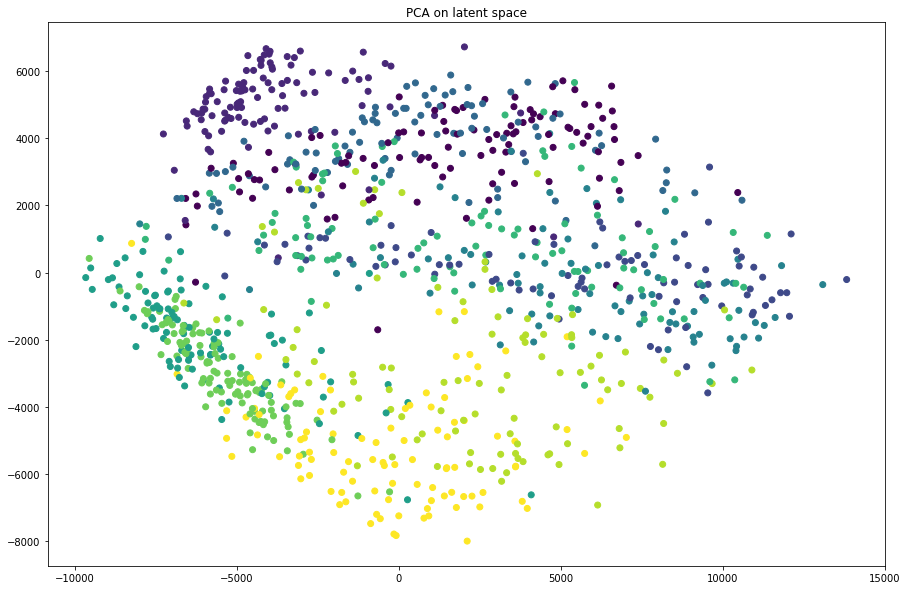

In [29]:
u6.plot_PCA_hidden(model, train_loader, device, input_dim, 'PCA on latent space', 1000)

Repeat the <i>principal component analysis</i>, while considering only the following <i>targets/classes</i>:

- $c = (0, 7, 8)$

Is the result of the <i>PCA</i> applied on only those <i>three</i> classes more distinctive compared to the previous plot (which considered <i>all</i> classes)? Experiment with different <i>targets</i>, which are $\ldots$

- $\ldots$ <i>similar</i> to each other.
- $\ldots$ <i>different</i> to each other.

How does PCA work on them? Can you spot any differences when compared to PCA applied on the <i>input space</i> of the data set (instead of the <i>latent space</i>)? Try to comment on you answer, but keep in mind, to compare the <i>same subset</i> of <i>targets</i>.

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

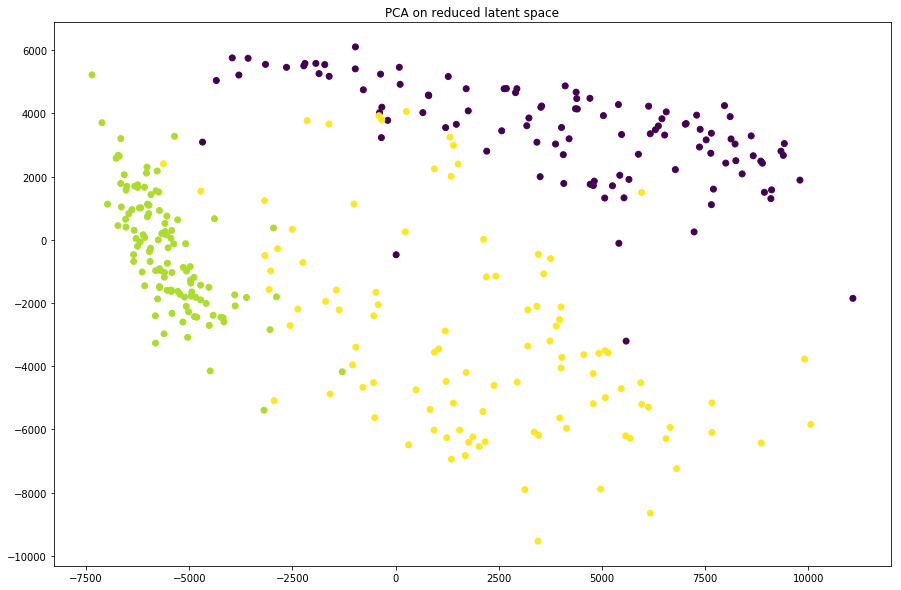

In [30]:
u6.plot_PCA_hidden_reduced(model, train_loader, device, input_dim, 'PCA on reduced latent space', 
                           1000, [0, 7, 8])

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

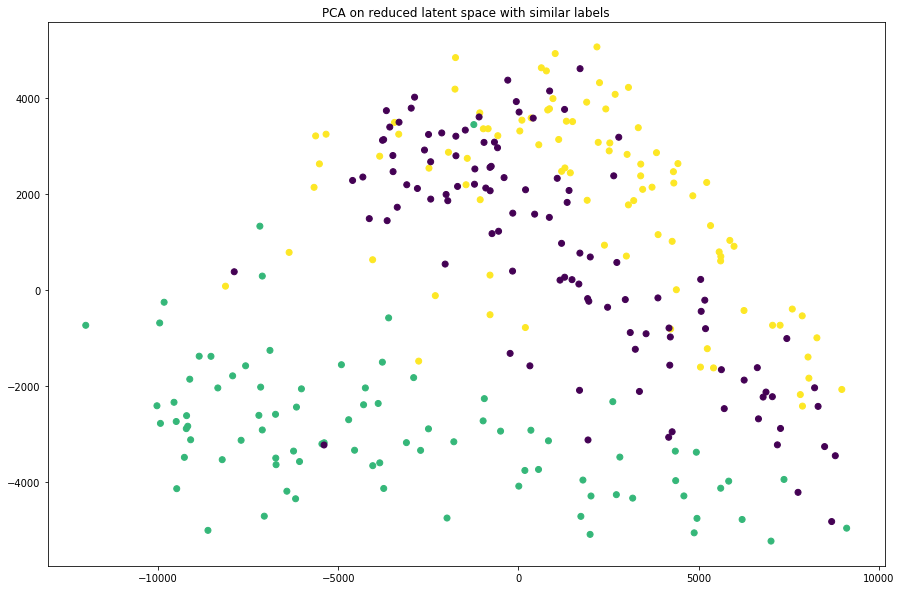

In [31]:
u6.plot_PCA_hidden_reduced(model, train_loader, device, input_dim, 'PCA on reduced latent space with similar labels', 
                           1000, [0, 2, 3])

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

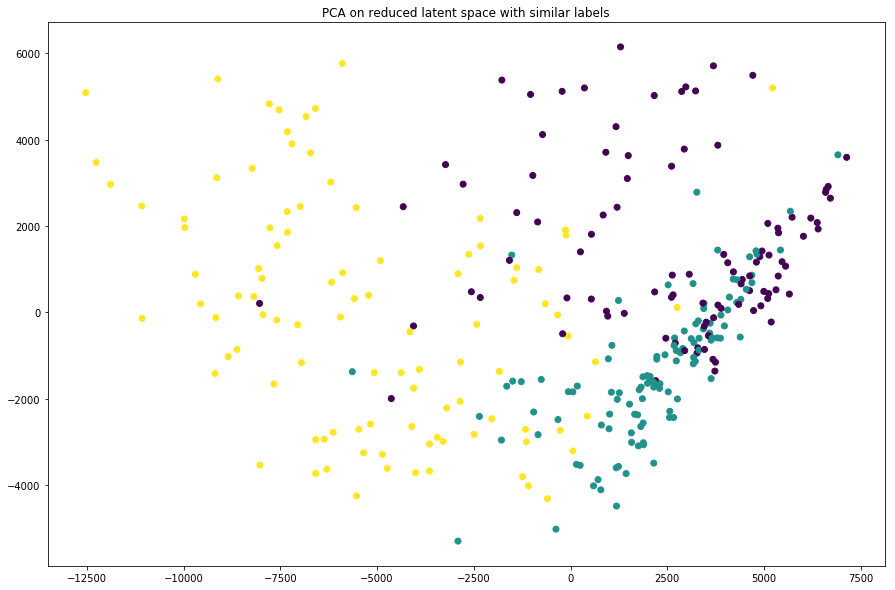

In [32]:
u6.plot_PCA_hidden_reduced(model, train_loader, device, input_dim, 'PCA on reduced latent space with similar labels', 
                            1000, [5, 7, 9])

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

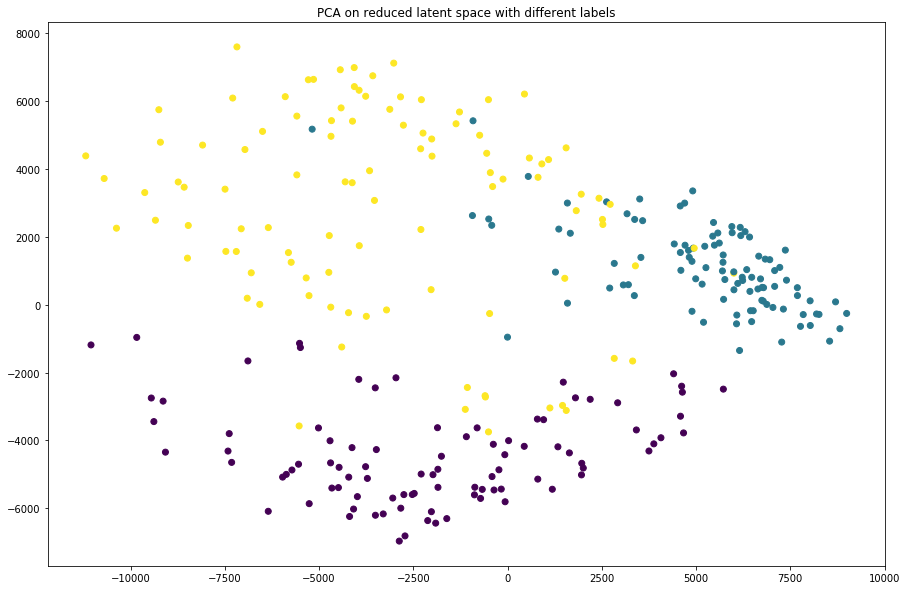

In [33]:
u6.plot_PCA_hidden_reduced(model, train_loader, device, input_dim, 'PCA on reduced latent space with different labels', 
                           1000, [3, 5, 8])

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

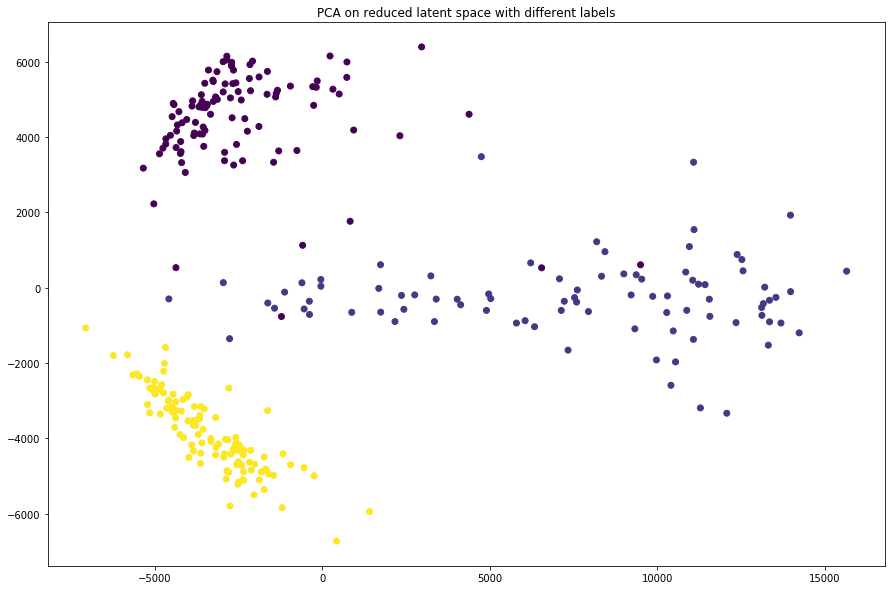

In [34]:
u6.plot_PCA_hidden_reduced(model, train_loader, device, input_dim, 'PCA on reduced latent space with different labels', 
                           1000, [1, 2, 7])

# Answer
Regarding the differences between plots resulting in applying the normal PCA and some resulting in using the reduced PCA, the same obersvations as with the input space can be made:

### Difference between normal PCA and PCA reduced
In general the targets can be better distinguished when using only a few than all.

### Difference between plots with different targets using PCA reduced
Different clusters are much better visible when using three labels that are not very similar (e.g. dress, sandal, bag). When using targets that are very similar to each other (e.g. T-shirt, pullover, dress) the different clusters are much more mixed up.

## Differences between PCA applied to latent space and input space
<b>The plots resulting when applying the PCA to the latent space seem to be very, very similar to the plots which are resulting when applying the PCA to the input space, but rotated or flipped in some way.</b>
E.g.:

- "normal", not reduced PCA: The latent-space-plot is the input-space-plot rotated by 180°.
- reduced PCA, (0, 7, 8): The latent-space-plot is more or less the input-space-plot flipped vertically.
- reduced PCA, (0, 2, 3): The latent-space-plot is more or less the input-space-plot flipped horizontally.
- reduced PCA, (5, 7, 9): The latent-space-plot is more or less the input-space-plot flipped horizontally.
- reduced PCA, (3, 5, 8): The latent-space-plot is more or less the input-space-plot flipped horizontally.
- reduced PCA, (1, 2, 7): The latent-space-plot is more or less the input-space-plot flipped vertically.

The results of the two dimensionality reduction techniques, <i>principal component analysis</i> and <i>t-distributed neighbor embedding</i>, might vary a lot. Hence, your <b>second task</b> of this exercise comprises the analysis of the <i>latent space</i> of some Fashion-MNIST entries using <i>t-SNE</i>.

- Set the <i>random seed</i> to $s = 42$ using the <i>numpy</i> interface.
- Apply <i>t-SNE</i> on the <i>latent representation</i> of the first $n = 1000$ entries and project them down to <i>two</i> components.
- Display the resulting data in a colored <i>scatter plot</i>.

Hint: the latter two steps can be performed at <i>once</i> (look at the notebook presented during the lecture or the accompanying <code>u6_utils.py</code> file).

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

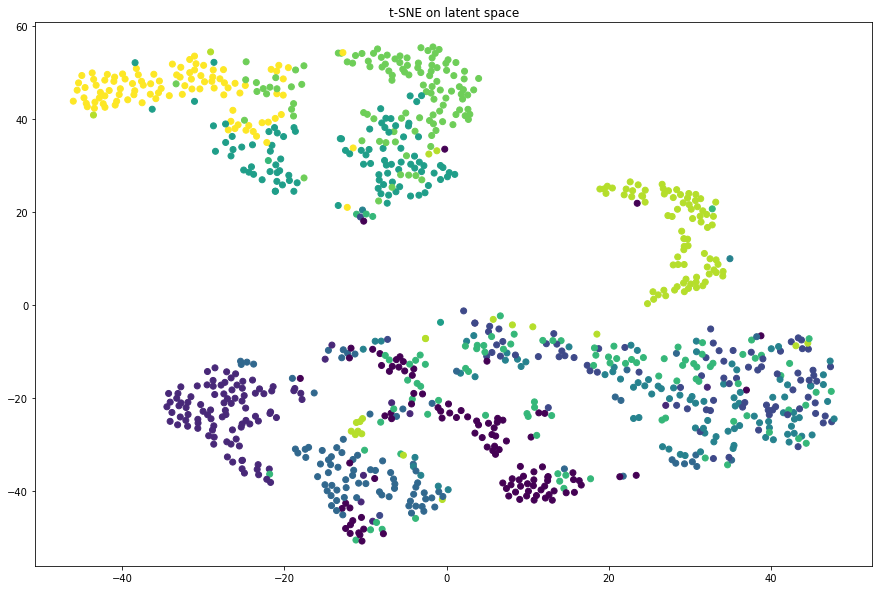

In [35]:
np.random.seed(42)
u6.plot_tsne_hidden(model, train_loader, device, input_dim, 't-SNE on latent space', 1000)

Repeat the <i>t-distributed stochastic neighbor embedding</i> approach, while considering only the following <i>targets/classes</i>:

- $c = (0, 7, 8)$

Is the result of the <i>t-SNE</i> applied on only those <i>three</i> classes more distinctive compared to the previous plot (which considered <i>all</i> classes)? Experiment with different <i>targets</i>, which are $\ldots$

- $\ldots$ <i>similar</i> to each other.
- $\ldots$ <i>different</i> to each other.

How does t-SNE work on them? Can you spot any differences when compared to t-SNE applied on the <i>input space</i> of the data set (instead of the <i>latent space</i>)? Try to comment on you answer, but keep in mind, to compare the <i>same subset</i> of <i>targets</i>.

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

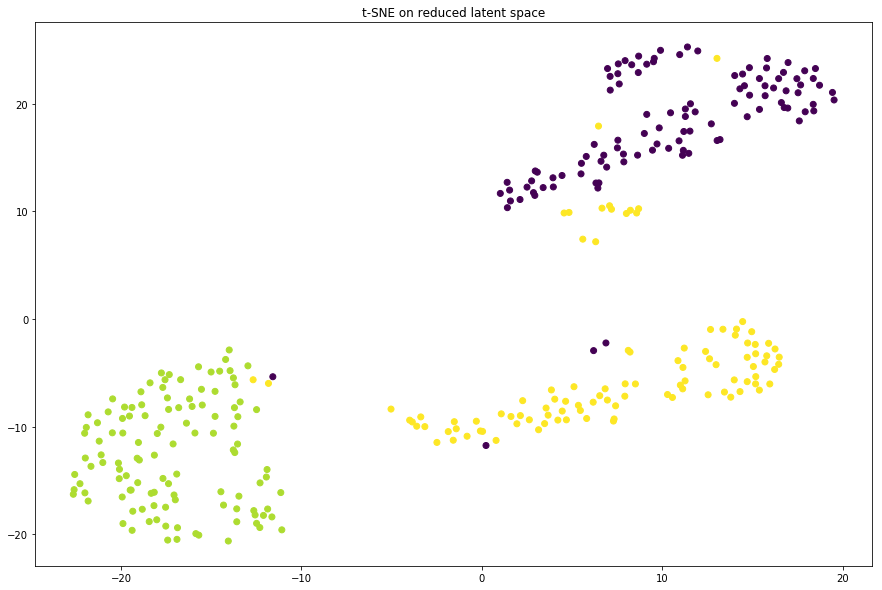

In [36]:
u6.plot_tsne_hidden_reduced(model, train_loader, device, input_dim, 't-SNE on reduced latent space',
                           1000, [0, 7, 8])

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

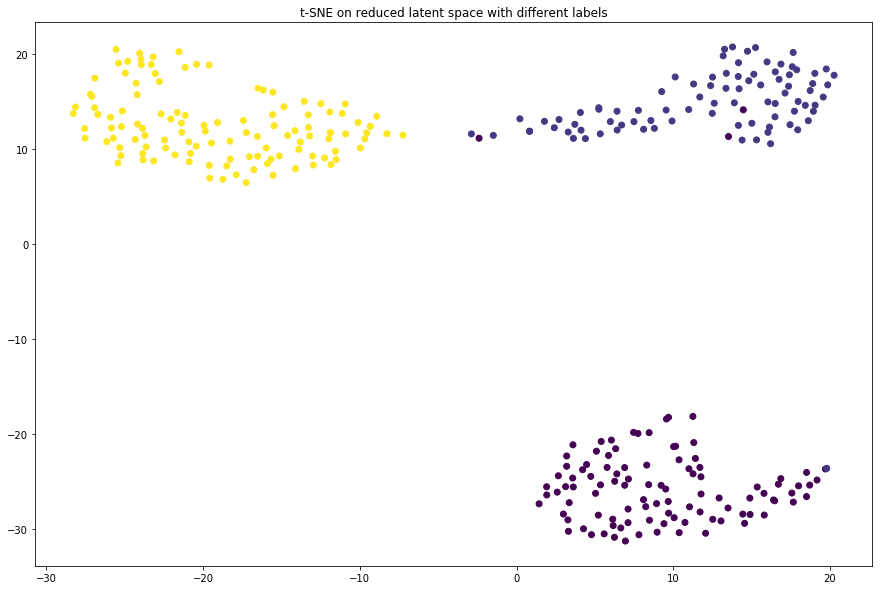

In [37]:
u6.plot_tsne_hidden_reduced(model, train_loader, device, input_dim, 't-SNE on reduced latent space with different labels',
                           1000, [1, 2, 7])

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

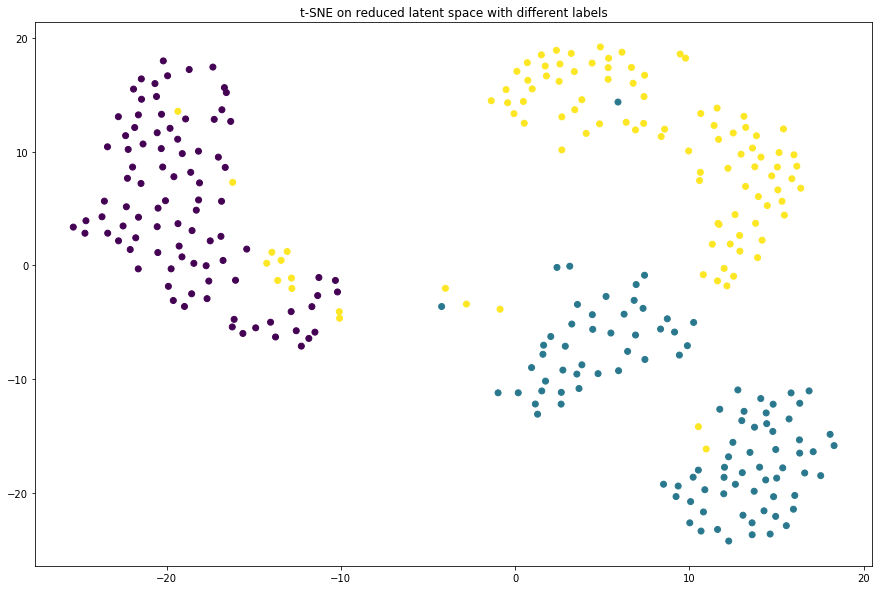

In [38]:
u6.plot_tsne_hidden_reduced(model, train_loader, device, input_dim, 't-SNE on reduced latent space with different labels',
                           1000, [3, 5, 8])

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

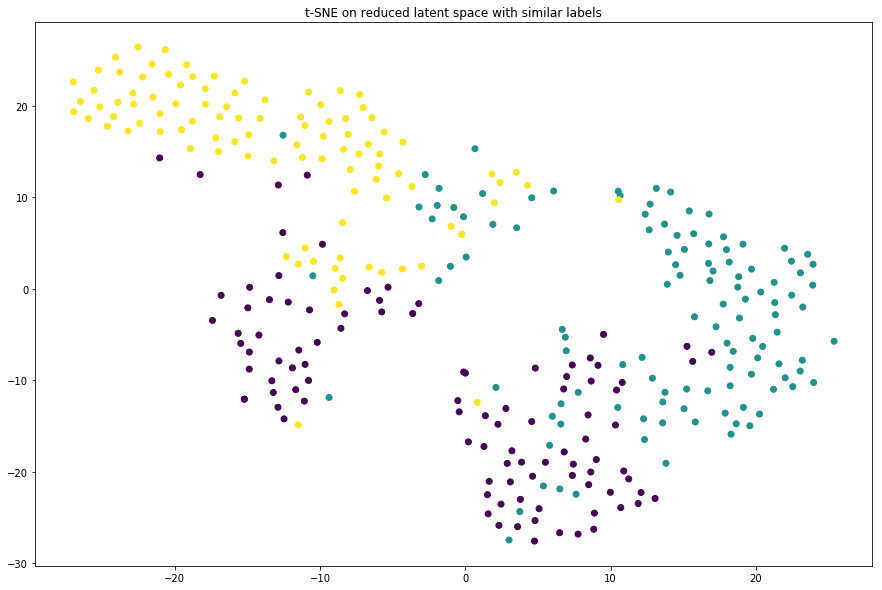

In [39]:
u6.plot_tsne_hidden_reduced(model, train_loader, device, input_dim, 't-SNE on reduced latent space with similar labels',
                           1000, [5, 7, 9])

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

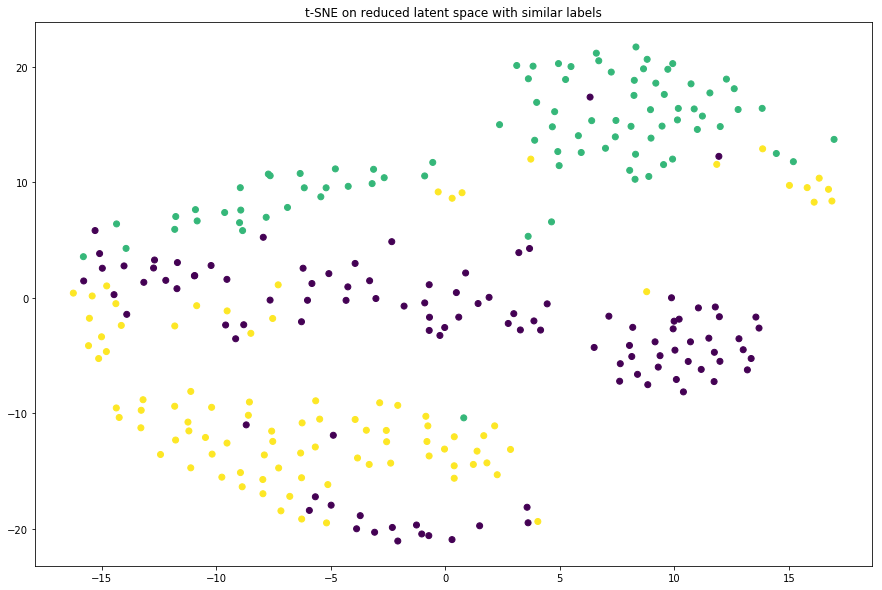

In [40]:
u6.plot_tsne_hidden_reduced(model, train_loader, device, input_dim, 't-SNE on reduced latent space with similar labels',
                           1000, [0, 2, 3])

# Answer
Regarding the differences between plots resulting in applying the normal t-SNE and some resulting in using the reduced t-SNE, the same obersvations as with the input space can be made:

### Difference between normal t-SNE and t-SNE reduced
In general the targets can be better distinguished when using only a few than all.

### Difference between plots with different targets using t-SNE reduced
Different clusters are much better visible when using three labels that are not very similar (e.g. dress, sandal, bag). When using targets that are very similar to each other (e.g. T-shirt, pullover, dress) the different cluster are much more mixed up

## Differences between t-SNE applied to latent space and input space
<b>The plots resulting when applying the t-SNE to the latent space seem to be very, very similar to the plots which are resulting when applying the t-SNE to the input space, but rflipped in some way.</b>
E.g.:

- "normal", not reduced t-SNE: The latent-space-plot is more or less the input-space-plot flipped horizontally.
- reduced t-SNE, (0, 7, 8): Here, it seems that just the yellow cluster has moved a little bit when comparing the latent-space-plot and the input-space-plot. The rest stayed approximately the same.
- reduced t-SNE, (1, 2, 7): The latent-space-plot is more or less the input-space-plot flipped vertically.
- reduced t-SNE, (3, 5, 8): The latent-space-plot is more or less the input-space-plot flipped diagonally but with some a little bit bigger differences.
- reduced t-SNE, (5, 7, 9): The latent-space-plot is more or less the input-space-plot flipped diagonally.
- reduced t-SNE, (0, 2, 3): The latent-space-plot is more or less the same as the input-space-plot.

Reducing the dimensionality and plotting the result is not the only interesting analysis of a <i>hidden representation</i> of some data entries. Especially fascinating is the possibility to <i>walk</i> in the <i>latent space</i> from <i>one</i> data point to <i>another</i>. The <b>third</b> and <b>last task</b> of this exercise requires you to explore the <i>latent space</i> of the trained <i>autoencoder</i> model.

- Create a <i>subdirectory</i> termed <code>samples</code> in the current working directory.
- Fetch the <i>next</i> batch of the data loader connected to the <i>training</i> set.
- Apply the trained <i>autoencoder</i> model to said batch.

Now it would be interesting to actually <i>see</i> the result of the <i>decoding</i> step of the <i>autoencoder</i>. Therefore:

- Save the <i>decoded</i> latent representation to <code>./samples/x_ae_decoded.png</code> (keep in mind to <i>reshape</i> the tensor accordingly).
- Read and <i>display</i> the just created file (<i>hint</i>: have a look at the notebook presented during the <i>lecture</i>).

In [41]:
if not os.path.exists(os.path.join(r'.', r'samples')):
    os.makedirs(os.path.join(r'.', r'samples'))

In [42]:
data, _ = next(iter(train_loader))
data = data.view(-1, input_dim)
hidden,output = model(data)

In [43]:
u6.save_image(output.data.view(args.batch_size, 1, 28, 28), './samples/x_ae_decoded.png')

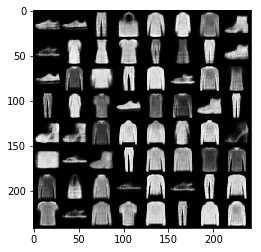

In [44]:
img_ae_hiden = mpimg.imread('./samples/x_ae_decoded.png')
plt.imshow(img_ae_hiden)

Choose <i>two</i> decoded entries of the previous image using the following <i>indexing</i> of an <i>entry</i> (note, that the index is computed <i>row-wise</i>):

\begin{equation}
    e_{i} = j_{row} \cdot{} d_{row} + j_{column}
\end{equation}

Whereas the single parts refer to:

- $e_{i}$ corresponds to the <i>i-th</i> entry.
- $d_{row}$ defines the amount of <i>entries</i> per row.
- $j_{row}$ specifies the <i>row</i> index (zero-based).
- $j_{column}$ specifies the <i>column</i> index (zero-based).

Plot both <i>chosen</i> entries using this notation to verify the <i>correct</i> indexing of your choices.

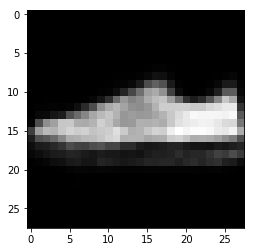

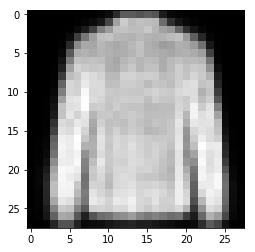

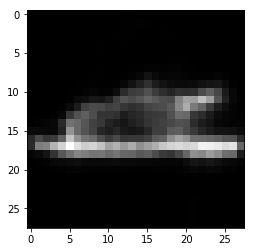

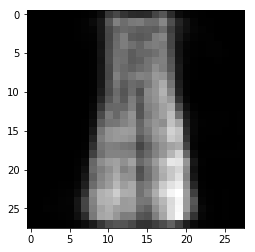

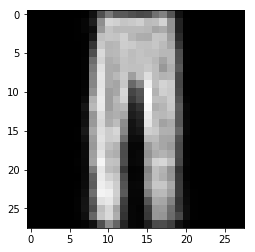

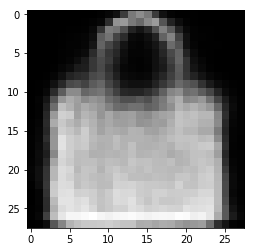

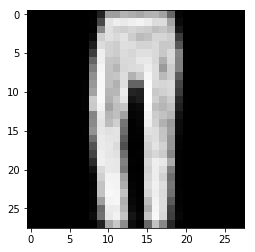

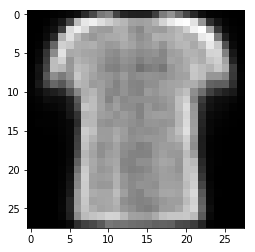

In [45]:
# different examples
example1 = 0*8+1 
example2 = 7*8+2

example3 = 7*8+1 # similar to example1
example4 = 1*8+5 # similar to example2

u6.plot_example(output, example1)
u6.plot_example(output, example2)

# different examples
example5 = 0*8+2
example6 = 0*8+3

example7 = 6*8+6 # similar to example5
example8 = 7*8+0 # (more or less) similar to example6

u6.plot_example(output, example3)
u6.plot_example(output, example4)
u6.plot_example(output, example5)
u6.plot_example(output, example6)
u6.plot_example(output, example7)
u6.plot_example(output, example8)

Now comes the fun part: the actual <i>walk</i> in the <i>latent space</i>. For this very purpose, the following steps are required:

- Walk in the latent space using the <code>walk_in_latent_space</code> method of <code>u6_utils.py</code> (save the result in <code>x_ae_walk.png</code>).
- Read and <i>display</i> the just created file (keep in mind, that the result of the previous step is saved in the <code>samples</code> subdirectory).

Experiment with different <i>entries</i>, which are $\ldots$

- $\ldots$ <i>similar</i> to each other.
- $\ldots$ <i>different</i> to each other.

Try to comment on the <i>transition</i> phase. Are some targets <i>more</i> suited to be transitioned into each other than others? Try to argue about <i>possible</i> reasons.

In [46]:
u6.walk_in_latent_space(model, hidden, example1, example2, args.batch_size, hidden_dim_0, device, "x_ae_walk.png")

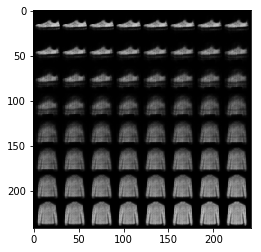

In [47]:
img_ae_walk = mpimg.imread('./samples/x_ae_walk.png')
plt.imshow(img_ae_walk)

## Answer
Shoes and sweaters are not that well suited to be transistioned into each other, because the images in the transition phase seem to be relatively meaningless.

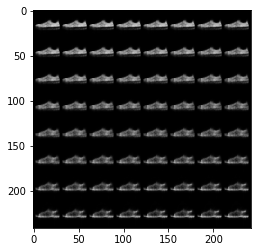

In [48]:
# shoe and shoe, similar
u6.walk_in_latent_space(model, hidden, example1, example3, args.batch_size, hidden_dim_0, device, "x_ae_walk.png")
img_ae_walk = mpimg.imread('./samples/x_ae_walk.png')
plt.imshow(img_ae_walk)

## Answer
Shoes and shoes seem to be more or less well suited to be transitioned into "each other", because during the transistion phase, some "new" shoes are occuring.

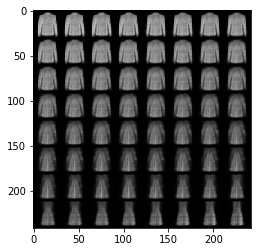

In [49]:
# sweater and dress, similar
u6.walk_in_latent_space(model, hidden, example2, example4, args.batch_size, hidden_dim_0, device, "x_ae_walk.png")
img_ae_walk = mpimg.imread('./samples/x_ae_walk.png')
plt.imshow(img_ae_walk)

## Answer
Sweaters and dresses seem to be well suited to be transistioned into each other. During the transistion phase some interesting fasion items are occuring.

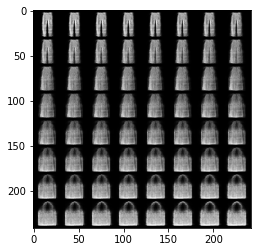

In [50]:
# pants and bag, different
u6.walk_in_latent_space(model, hidden, example5, example6, args.batch_size, hidden_dim_0, device, "x_ae_walk.png")
img_ae_walk = mpimg.imread('./samples/x_ae_walk.png')
plt.imshow(img_ae_walk)

## Answer
Pants and bags don't seem to be fitted to be transformed into each other. The images which are occuring during the transistion phase don't seem to be very meaningful. Maybe, with much imagination, one could see a dress in the images of the transistion phase here or there.

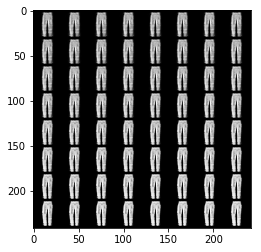

In [51]:
# pants and pants, similar
u6.walk_in_latent_space(model, hidden, example5, example7, args.batch_size, hidden_dim_0, device, "x_ae_walk.png")
img_ae_walk = mpimg.imread('./samples/x_ae_walk.png')
plt.imshow(img_ae_walk)

## Answer
Here, the same as with shoes and shoes hold: Pants and pants seem to be more or less well suited to be transitioned into "each other", because during the transistion phase, some "new" pants are occuring.

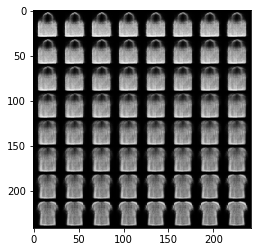

In [52]:
# bag and shirt, (more or less) similar
u6.walk_in_latent_space(model, hidden, example6, example8, args.batch_size, hidden_dim_0, device, "x_ae_walk.png")
img_ae_walk = mpimg.imread('./samples/x_ae_walk.png')
plt.imshow(img_ae_walk)

## Answer
Bags and shirt, even though they look something like a little bit similar, are not very well suited to be transitioned into each other.

# Over-all-answer
Over all, images with similar targets are better suited to be transformed into each other than very different-looking images. Reason for this is that when transistioning images with similar targets into each other, during the transistion phase here or there meaningful, <b>new</b> images are occuring whereas this is not the case with images with very different targets.

At the beginning of <i>this</i> exercise, the following statement was boldly claimed:

<cite>Moreover, as the family of the models of interest are of a <i>generative</i> nature, we can actually utilize them to <i>generate</i> new (related) samples.</cite>

But up until now, no <i>new</i> real content was produced. The previous <i>walk</i> in the <i>latent space</i> is a step in the right direction, but still <i>not</i> what said statement seemed to <i>promise</i>. Now is the time to <i>change</i> that:

- Create a <i>random</i> <code>Variable</code> of size $d_{batch} \times{} d_{h}$.
- Use the <code>decoder</code> member of the <i>autoencoder</i> model to process the just created <i>random variable</i>.
- Save the <i>decoded</i> random representation to <code>./samples/x_ae_random.png</code> (keep in mind to <i>reshape</i> the tensor accordingly).
- Read and <i>display</i> the just created file (<i>hint</i>: have a look at the notebook presented during the lecture).

What do you observe? Those <i>newly</i> created images are <i>nice</i> and <i>beautiful</i>, aren't they? If <i>not</i>, try to comment on <i>possible</i> reasons.

In [53]:
sample = Variable(torch.randn(args.batch_size, hidden_dim_0)).to(device)
sample = model.decoder(sample).to(device)
u6.save_image(sample.data.view(args.batch_size, 1, 28, 28), './samples/x_ae_random.png')

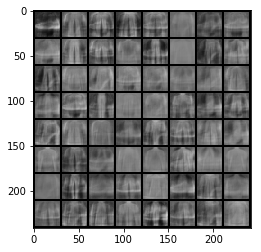

In [54]:
img_ae_random = mpimg.imread('./samples/x_ae_random.png')
plt.imshow(img_ae_random)

# Answer
The generated images don't exactly look nice and/or beautiful, indeed. They rather look very random and meaningless. 

A possible reason for this could be that the autoencoder just learns to compress and decompress the input data, it doesn't learn anything about the actual structure of the inputdata. Therefore, when trying to decode some random Variable, a likely random result follows.

# Exercise 3
After <i>experimenting</i> with <i>autoencoders</i> and <i>analyzing</i> the <i>latent space</i> of them, some problems might have arisen. Fortunately, there is a slight adaption of the <i>plain</i> autoencoder introducing a nice property with respect to <i>content creation</i> (more on this later in this exercise): <i>variational autoencoders</i>. To get you started, the <b>first task</b> of this exercise requires you to perform the following steps:

- Set the dimensionality of the latent space to be $d_{h} = 10$.
- Define a <code>VAE</code> instance (supplied by <code>u6_utils.py</code>) using previously defined input dimensionality $d_{in}$.
- Define an <code>Adam</code> instance using previously defined <i>hyperparameters</i>.

Train the newly defined <i>variational autoencoder</i> model by applying the corresponding <i>data loader</i> (keep in mind for which set we want the model to be <i>trained</i>) as well as the <i>optimizer</i>. Experiment with <i>different</i> values for $d_{h}$ and report their performances on the <i>test set</i> afterwards.

In [55]:
hidden_dim_vae = 10
model_vae = u6.VAE(input_dim, hidden_dim_vae).to(device)
optimizer_vae = torch.optim.Adam(model_vae.parameters(), lr=args.lr, weight_decay=args.weight_decay)

In [56]:
for epoch in range(1, args.epochs + 1):
    u6.train_variational_autoencoder(args, model_vae, device, train_loader, input_dim, optimizer_vae, epoch)
    u6.test_variational_autoencoder(args, model_vae, device, test_loader, input_dim)

Train Epoch: 1 [0/60000 (0%)]	Loss: 35206.031250
Train Epoch: 1 [6400/60000 (11%)]	Loss: 20284.896484
Train Epoch: 1 [12800/60000 (21%)]	Loss: 16900.789062
Train Epoch: 1 [19200/60000 (32%)]	Loss: 17304.556641
Train Epoch: 1 [25600/60000 (43%)]	Loss: 17336.535156
Train Epoch: 1 [32000/60000 (53%)]	Loss: 16986.208984
Train Epoch: 1 [38400/60000 (64%)]	Loss: 16376.162109
Train Epoch: 1 [44800/60000 (75%)]	Loss: 16696.125000
Train Epoch: 1 [51200/60000 (85%)]	Loss: 16296.449219
Train Epoch: 1 [57600/60000 (96%)]	Loss: 15452.599609

Test set loss: 251024.4578
Train Epoch: 2 [0/60000 (0%)]	Loss: 16657.636719
Train Epoch: 2 [6400/60000 (11%)]	Loss: 16529.615234
Train Epoch: 2 [12800/60000 (21%)]	Loss: 16368.833008
Train Epoch: 2 [19200/60000 (32%)]	Loss: 15650.974609
Train Epoch: 2 [25600/60000 (43%)]	Loss: 15216.965820
Train Epoch: 2 [32000/60000 (53%)]	Loss: 15846.260742
Train Epoch: 2 [38400/60000 (64%)]	Loss: 15829.250000
Train Epoch: 2 [44800/60000 (75%)]	Loss: 15590.261719
Train Epoch:

In [57]:
def train_different_hidden_dims_vae(hidden_dim):
    model = u6.VAE(input_dim, hidden_dim).to(device)
    optimizer = torch.optim.Adam(
        model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    for epoch in range(1, args.epochs + 1):
        u6.train_variational_autoencoder(args, model, device, train_loader, input_dim, optimizer, epoch)
        u6.test_variational_autoencoder(args, model, device, test_loader, input_dim)
    del model

In [58]:
# hidden_dim = 1

train_different_hidden_dims_vae(1)

Train Epoch: 1 [0/60000 (0%)]	Loss: 35482.222656
Train Epoch: 1 [6400/60000 (11%)]	Loss: 21185.722656
Train Epoch: 1 [12800/60000 (21%)]	Loss: 19611.750000
Train Epoch: 1 [19200/60000 (32%)]	Loss: 21162.689453
Train Epoch: 1 [25600/60000 (43%)]	Loss: 18525.410156
Train Epoch: 1 [32000/60000 (53%)]	Loss: 19813.371094
Train Epoch: 1 [38400/60000 (64%)]	Loss: 19328.005859
Train Epoch: 1 [44800/60000 (75%)]	Loss: 20767.785156
Train Epoch: 1 [51200/60000 (85%)]	Loss: 20066.847656
Train Epoch: 1 [57600/60000 (96%)]	Loss: 17635.853516

Test set loss: 306840.3125
Train Epoch: 2 [0/60000 (0%)]	Loss: 18477.767578
Train Epoch: 2 [6400/60000 (11%)]	Loss: 20389.255859
Train Epoch: 2 [12800/60000 (21%)]	Loss: 20779.849609
Train Epoch: 2 [19200/60000 (32%)]	Loss: 19727.031250
Train Epoch: 2 [25600/60000 (43%)]	Loss: 20453.220703
Train Epoch: 2 [32000/60000 (53%)]	Loss: 19122.599609
Train Epoch: 2 [38400/60000 (64%)]	Loss: 18760.380859
Train Epoch: 2 [44800/60000 (75%)]	Loss: 19486.908203
Train Epoch:

In [59]:
# hidden_dim = 5

train_different_hidden_dims_vae(5)

Train Epoch: 1 [0/60000 (0%)]	Loss: 35083.507812
Train Epoch: 1 [6400/60000 (11%)]	Loss: 19427.361328
Train Epoch: 1 [12800/60000 (21%)]	Loss: 16948.273438
Train Epoch: 1 [19200/60000 (32%)]	Loss: 17257.591797
Train Epoch: 1 [25600/60000 (43%)]	Loss: 17140.132812
Train Epoch: 1 [32000/60000 (53%)]	Loss: 17586.640625
Train Epoch: 1 [38400/60000 (64%)]	Loss: 16400.638672
Train Epoch: 1 [44800/60000 (75%)]	Loss: 16336.145508
Train Epoch: 1 [51200/60000 (85%)]	Loss: 17099.306641
Train Epoch: 1 [57600/60000 (96%)]	Loss: 15981.401367

Test set loss: 253183.5156
Train Epoch: 2 [0/60000 (0%)]	Loss: 15911.931641
Train Epoch: 2 [6400/60000 (11%)]	Loss: 17088.541016
Train Epoch: 2 [12800/60000 (21%)]	Loss: 15938.831055
Train Epoch: 2 [19200/60000 (32%)]	Loss: 15822.583984
Train Epoch: 2 [25600/60000 (43%)]	Loss: 15746.989258
Train Epoch: 2 [32000/60000 (53%)]	Loss: 15136.835938
Train Epoch: 2 [38400/60000 (64%)]	Loss: 16676.312500
Train Epoch: 2 [44800/60000 (75%)]	Loss: 13804.460938
Train Epoch:

In [60]:
# hidden_dim = 15

train_different_hidden_dims_vae(15)

Train Epoch: 1 [0/60000 (0%)]	Loss: 35140.882812
Train Epoch: 1 [6400/60000 (11%)]	Loss: 19347.884766
Train Epoch: 1 [12800/60000 (21%)]	Loss: 17640.927734
Train Epoch: 1 [19200/60000 (32%)]	Loss: 16869.957031
Train Epoch: 1 [25600/60000 (43%)]	Loss: 16545.988281
Train Epoch: 1 [32000/60000 (53%)]	Loss: 16365.409180
Train Epoch: 1 [38400/60000 (64%)]	Loss: 16632.244141
Train Epoch: 1 [44800/60000 (75%)]	Loss: 17978.541016
Train Epoch: 1 [51200/60000 (85%)]	Loss: 17521.144531
Train Epoch: 1 [57600/60000 (96%)]	Loss: 15887.246094

Test set loss: 252439.5984
Train Epoch: 2 [0/60000 (0%)]	Loss: 16215.792969
Train Epoch: 2 [6400/60000 (11%)]	Loss: 16764.058594
Train Epoch: 2 [12800/60000 (21%)]	Loss: 16894.716797
Train Epoch: 2 [19200/60000 (32%)]	Loss: 16002.105469
Train Epoch: 2 [25600/60000 (43%)]	Loss: 16069.348633
Train Epoch: 2 [32000/60000 (53%)]	Loss: 15610.985352
Train Epoch: 2 [38400/60000 (64%)]	Loss: 15434.059570
Train Epoch: 2 [44800/60000 (75%)]	Loss: 15201.818359
Train Epoch:

In [61]:
# hidden_dim = 50

train_different_hidden_dims_vae(50)

Train Epoch: 1 [0/60000 (0%)]	Loss: 35106.347656
Train Epoch: 1 [6400/60000 (11%)]	Loss: 19986.128906
Train Epoch: 1 [12800/60000 (21%)]	Loss: 18686.261719
Train Epoch: 1 [19200/60000 (32%)]	Loss: 17810.187500
Train Epoch: 1 [25600/60000 (43%)]	Loss: 18841.519531
Train Epoch: 1 [32000/60000 (53%)]	Loss: 18091.703125
Train Epoch: 1 [38400/60000 (64%)]	Loss: 17111.597656
Train Epoch: 1 [44800/60000 (75%)]	Loss: 17498.804688
Train Epoch: 1 [51200/60000 (85%)]	Loss: 16463.039062
Train Epoch: 1 [57600/60000 (96%)]	Loss: 16949.318359

Test set loss: 261259.6500
Train Epoch: 2 [0/60000 (0%)]	Loss: 17613.517578
Train Epoch: 2 [6400/60000 (11%)]	Loss: 17465.773438
Train Epoch: 2 [12800/60000 (21%)]	Loss: 16669.189453
Train Epoch: 2 [19200/60000 (32%)]	Loss: 16470.466797
Train Epoch: 2 [25600/60000 (43%)]	Loss: 17288.083984
Train Epoch: 2 [32000/60000 (53%)]	Loss: 16685.208984
Train Epoch: 2 [38400/60000 (64%)]	Loss: 16385.818359
Train Epoch: 2 [44800/60000 (75%)]	Loss: 16391.298828
Train Epoch:

In [62]:
# hidden_dim = 1000

train_different_hidden_dims_vae(1000)

Train Epoch: 1 [0/60000 (0%)]	Loss: 35730.855469
Train Epoch: 1 [6400/60000 (11%)]	Loss: 21250.919922
Train Epoch: 1 [12800/60000 (21%)]	Loss: 18506.359375
Train Epoch: 1 [19200/60000 (32%)]	Loss: 18780.246094
Train Epoch: 1 [25600/60000 (43%)]	Loss: 18195.859375
Train Epoch: 1 [32000/60000 (53%)]	Loss: 18581.097656
Train Epoch: 1 [38400/60000 (64%)]	Loss: 18512.720703
Train Epoch: 1 [44800/60000 (75%)]	Loss: 18246.830078
Train Epoch: 1 [51200/60000 (85%)]	Loss: 17677.228516
Train Epoch: 1 [57600/60000 (96%)]	Loss: 17178.560547

Test set loss: 269640.6875
Train Epoch: 2 [0/60000 (0%)]	Loss: 17249.773438
Train Epoch: 2 [6400/60000 (11%)]	Loss: 18138.693359
Train Epoch: 2 [12800/60000 (21%)]	Loss: 17013.925781
Train Epoch: 2 [19200/60000 (32%)]	Loss: 17466.052734
Train Epoch: 2 [25600/60000 (43%)]	Loss: 17691.585938
Train Epoch: 2 [32000/60000 (53%)]	Loss: 16960.375000
Train Epoch: 2 [38400/60000 (64%)]	Loss: 17764.548828
Train Epoch: 2 [44800/60000 (75%)]	Loss: 16484.250000
Train Epoch:

In the previous exercise, PCA was applied on the <i>hidden</i> or <i>latent representation</i> of an <i>autoencoder</i> model. As a <i>variational</i> variant was trained in the meantime, it would be interesting and eventually insightful to compare the <i>hidden space</i> ob both approaches with respect to a distinction between the corresponding <i>targets/classes</i>. The <b>first task</b> of this exercise consists of the following steps:

- Apply <i>PCA</i> on the <i>latent representation</i> of the first $n = 1000$ entries and project them down to <i>two</i> components.
- Display the resulting data in a colored <i>scatter plot</i>.

Hint: both steps can be performed at <i>once</i> (look at the notebook presented during the lecture or the accompanying <code>u6_utils.py</code> file).

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

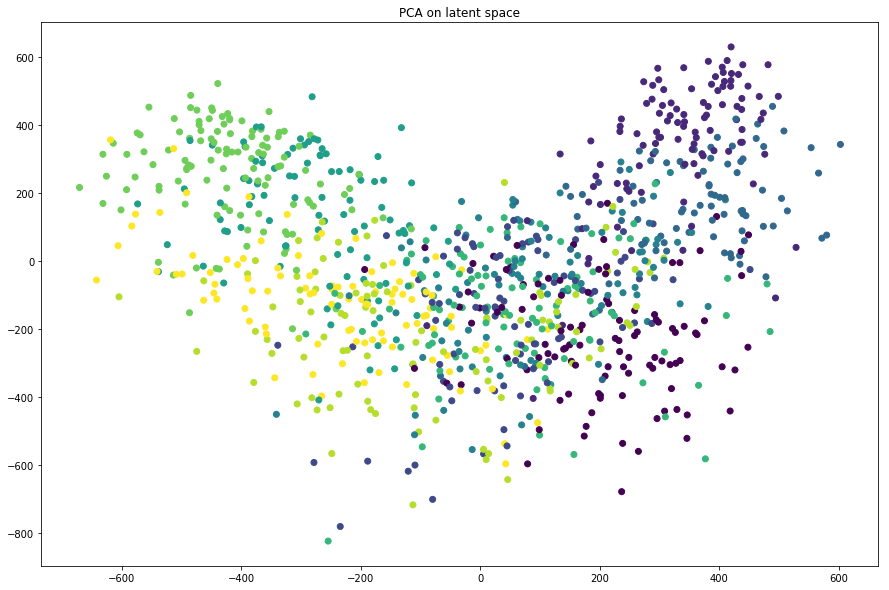

In [63]:
u6.plot_PCA_hidden(model_vae, train_loader, device, input_dim, 'PCA on latent space', 1000)

Repeat the <i>principal component analysis</i>, while considering only the following <i>targets/classes</i>:

- $c = (0, 7, 8)$

Is the result of the <i>PCA</i> applied on only those <i>three</i> classes more distinctive compared to the previous plot (which considered <i>all</i> classes)? Experiment with different <i>targets</i>, which are $\ldots$

- $\ldots$ <i>similar</i> to each other.
- $\ldots$ <i>different</i> to each other.

How does PCA work on them? Can you spot any differences when compared to PCA applied on the <i>input space</i> of the data set (instead of the <i>latent space</i>) and on the <i>hidden representation</i> of the <i>plain</i> autoencoder? Try to comment on you answer, but keep in mind, to compare the <i>same subset</i> of <i>targets</i>.

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

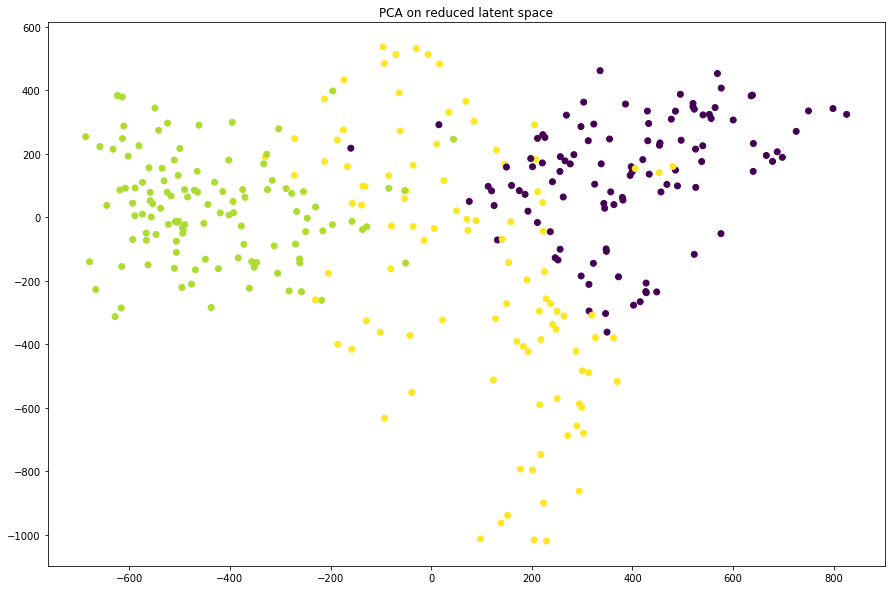

In [64]:
u6.plot_PCA_hidden_reduced(model_vae, train_loader, device, input_dim, 'PCA on reduced latent space', 
                           1000, [0, 7, 8])

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

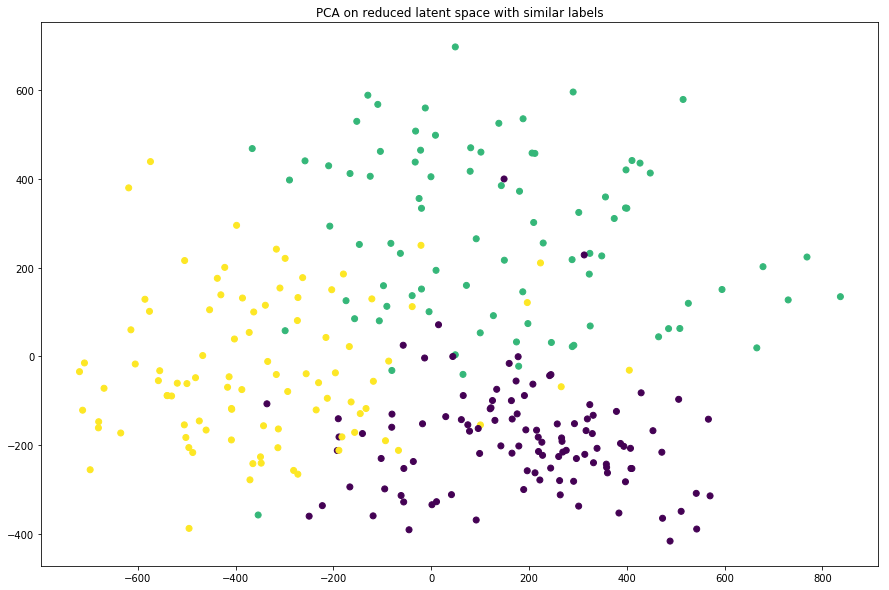

In [65]:
u6.plot_PCA_hidden_reduced(model_vae, train_loader, device, input_dim, 'PCA on reduced latent space with similar labels', 
                           1000, [0, 2, 3])

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

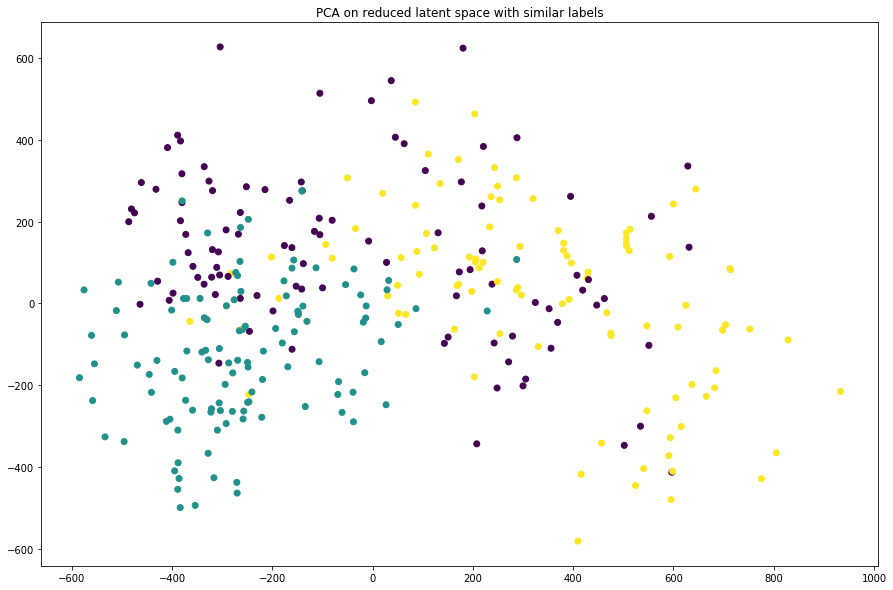

In [66]:
u6.plot_PCA_hidden_reduced(model_vae, train_loader, device, input_dim, 'PCA on reduced latent space with similar labels', 
                            1000, [5, 7, 9])

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

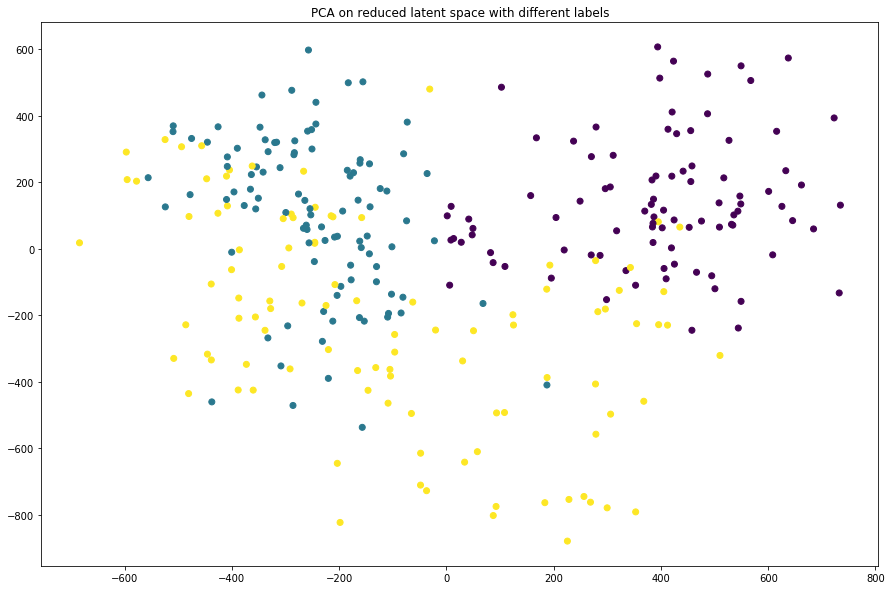

In [67]:
u6.plot_PCA_hidden_reduced(model_vae, train_loader, device, input_dim, 'PCA on reduced latent space with different labels', 
                           1000, [3, 5, 8])

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

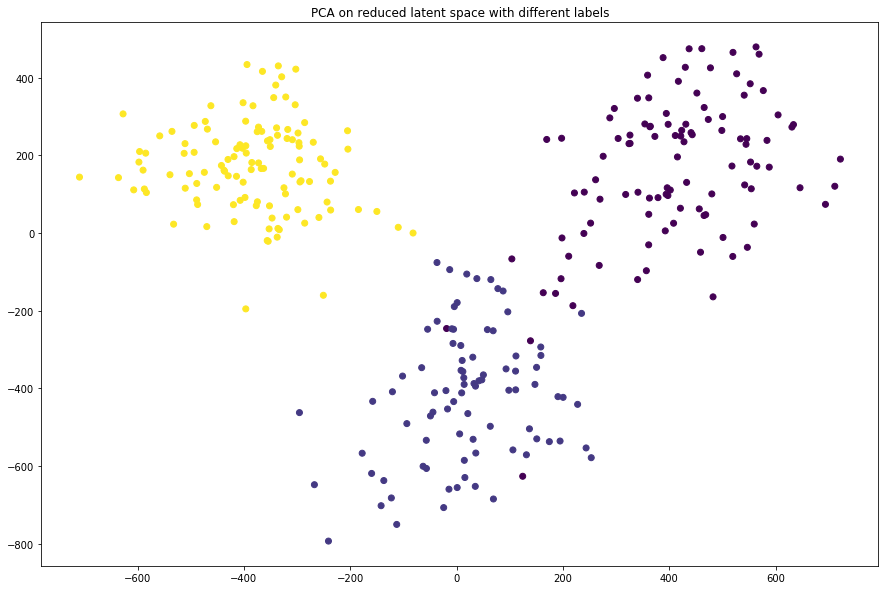

In [68]:
u6.plot_PCA_hidden_reduced(model_vae, train_loader, device, input_dim, 'PCA on reduced latent space with different labels', 
                           1000, [1, 2, 7])

# Answer
Regarding the differences between plots resulting in applying the normal PCA and some resulting in using the reduced PCA, the same obersvations as with the plain autoencoder can be made:

### Difference between normal PCA and PCA reduced
In general the targets can be better distinguished when using only a few than all.

### Difference between plots with different targets using PCA reduced
In this case, when using similar targets, the classes can be distiguished as good as when using different targets (one exception is (1, 2, 7) where the clusters are very well visible). The distribution of dots looks more or less the same in every plot (using reduced PCA).

## Differences between PCA applied to latent space using a VAE and PCA applied to latent space using a plain autoencoder
The observations described in the point "Difference between plots with different targets using PCA reduced" above are one major difference to the plain autoencoder, where this wasn't the case (see Exercise 2). In general, the datapoints in the plots using VAE seem to be very evenly (I mean "gleichmäßig") distributed which would fit with the nature of a VAE.

## Differences between PCA applied to latent space (VAE) and input space
When using the VAE it isn't the case anymore that the latent-space-plots are more or less the same like the input-space-plots, but rotated/flipped as it was the case with the plain autoencoder. Now, there are more differences between the plots. E.g. The datapoints are much more evenly distributed then applying the PCA on the input space.

The results of the two dimensionality reduction techniques, <i>principal component analysis</i> and <i>t-distributed neighbor embedding</i>, might vary a lot. Hence, your <b>second task</b> of this exercise comprises the analysis of the <i>latent space</i> of some Fashion-MNIST entries using <i>t-SNE</i>.

- Set the <i>random seed</i> to $s = 42$ using the <i>numpy</i> interface.
- Apply <i>t-SNE</i> on the <i>latent representation</i> of the first $n = 1000$ entries and project them down to <i>two</i> components.
- Display the resulting data in a colored <i>scatter plot</i>.

Hint: the latter two steps can be performed at <i>once</i> (look at the notebook presented during the lecture or the accompanying <code>u6_utils.py</code> file).

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

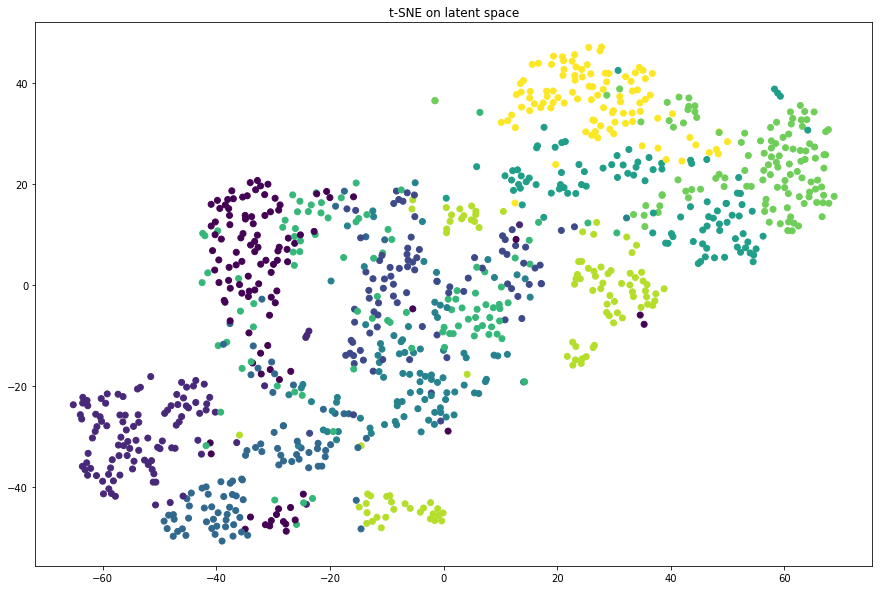

In [69]:
np.random.seed(42)
u6.plot_tsne_hidden(model_vae, train_loader, device, input_dim, 't-SNE on latent space', 1000)

Repeat the <i>t-distributed stochastic neighbor embedding</i> approach, while considering only the following <i>targets/classes</i>:

- $c = (0, 7, 8)$

Is the result of the <i>t-SNE</i> applied on only those <i>three</i> classes more distinctive compared to the previous plot (which considered <i>all</i> classes)? Experiment with different <i>targets</i>, which are $\ldots$

- $\ldots$ <i>similar</i> to each other.
- $\ldots$ <i>different</i> to each other.

How does t-SNE work on them? Can you spot any differences when compared to t-SNE applied on the <i>input space</i> of the data set (instead of the <i>latent space</i>) and on the <i>hidden representation</i> of the <i>plain</i> autoencoder? Try to comment on you answer, but keep in mind, to compare the <i>same subset</i> of <i>targets</i>.

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

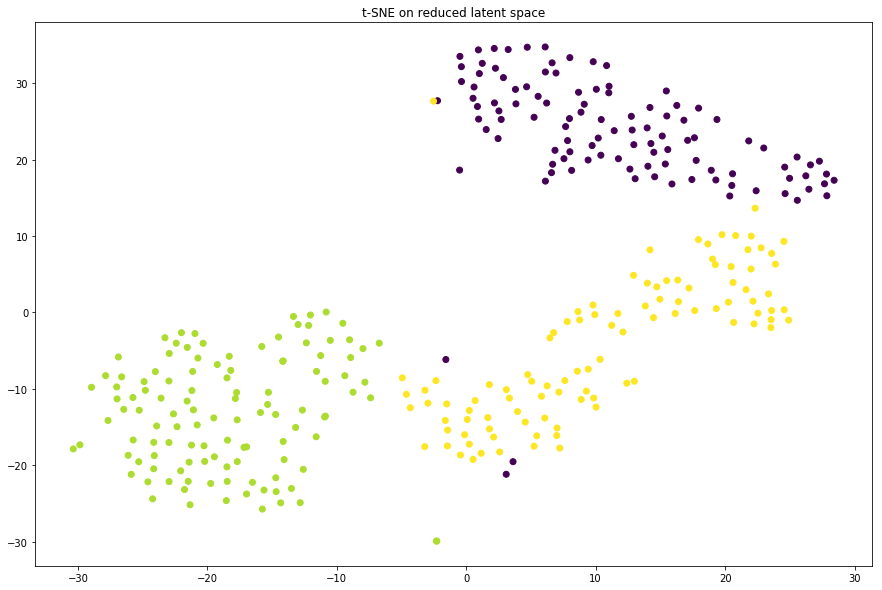

In [70]:
u6.plot_tsne_hidden_reduced(model_vae, train_loader, device, input_dim, 't-SNE on reduced latent space',
                           1000, [0, 7, 8])

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

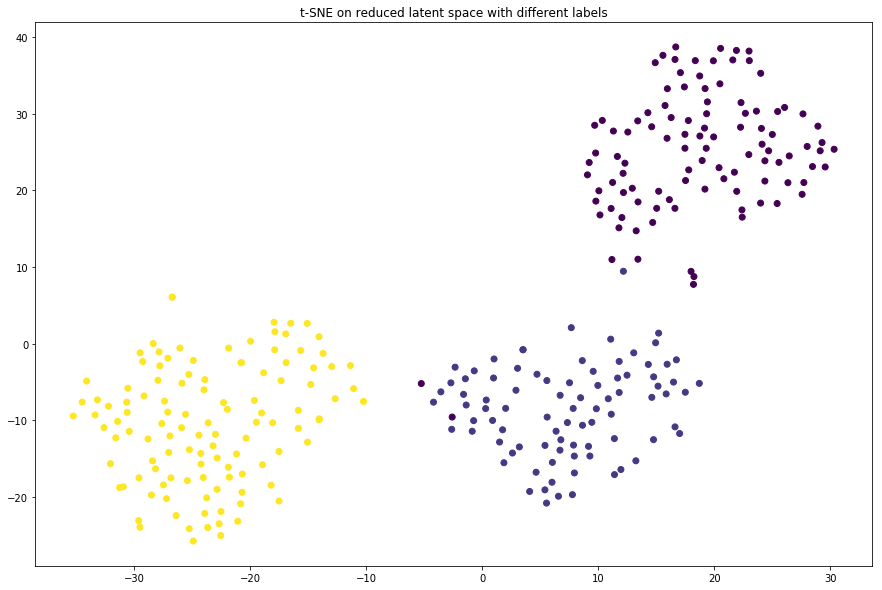

In [71]:
u6.plot_tsne_hidden_reduced(model_vae, train_loader, device, input_dim, 't-SNE on reduced latent space with different labels',
                           1000, [1, 2, 7])

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

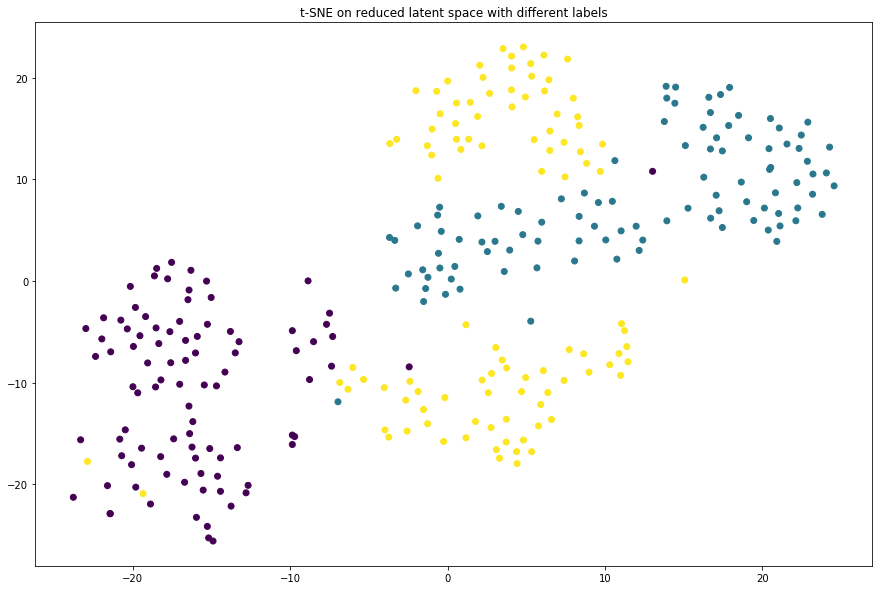

In [72]:
u6.plot_tsne_hidden_reduced(model_vae, train_loader, device, input_dim, 't-SNE on reduced latent space with different labels',
                           1000, [3, 5, 8])

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

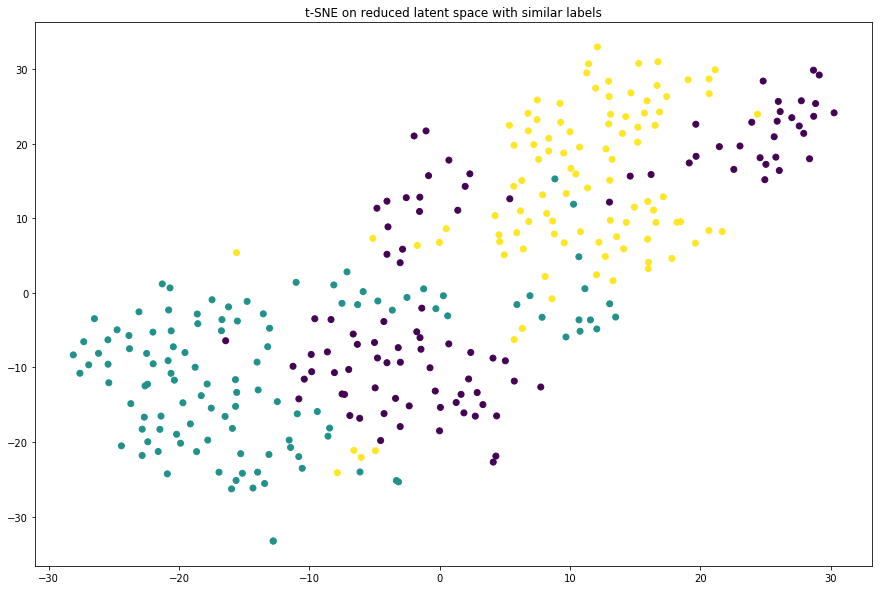

In [73]:
u6.plot_tsne_hidden_reduced(model_vae, train_loader, device, input_dim, 't-SNE on reduced latent space with similar labels',
                           1000, [5, 7, 9])

AttributeError: 'PathCollection' object has no attribute 'legend_elements'

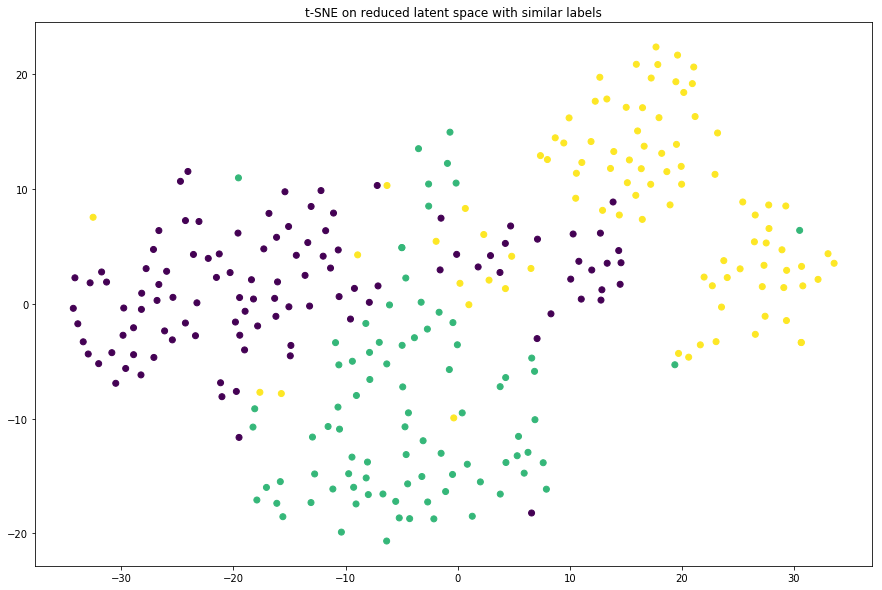

In [74]:
u6.plot_tsne_hidden_reduced(model_vae, train_loader, device, input_dim, 't-SNE on reduced latent space with similar labels',
                           1000, [0, 2, 3])

# Answer
Regarding the differences between plots resulting in applying the normal t-SNE and some resulting in using the reduced t-SNE, the same obersvations as with the plain autoencoder can be made:

### Difference between normal t-SNE and t-SNE reduced
In general the targets can be better distinguished when using only a few than all.

### Difference between plots with different targets using t-SNE reduced
Different clusters are much better visible when using three labels that are not very similar (e.g. dress, sandal, bag). When using targets that are very similar to each other (e.g. T-shirt, pullover, dress) the different cluster are much more mixed up

## Differences between t-SNE applied to latent space using a VAE and t-SNE applied to latent space using a plain autoencoder
From my point of view, the same happens like before with the PCA: The clusters are, in general, more mixed up with the VAE than with the plain autoencoder. Nevertheless, using t-SNE the classes are still very well distinguishable.

## Differences between t-SNE applied to latent space (VAE) and input space
The same as with the PCA above is the case:
When using the VAE it isn't the case anymore that the latent-space-plots are more or less the same like the input-space-plots, but rotated/flipped as it was the case with the plain autoencoder. Now, there are more differences between the plots. E. g. The datapoints are much more evenly distributed then applying the t-SNE on the input space.

Reducing the dimensionality and plotting the result is not the only interesting analysis of a <i>hidden representation</i> of some data entries. Especially fascinating is the possibility to <i>walk</i> in the <i>latent space</i> from <i>one</i> data point to <i>another</i>. The <b>third</b> and <b>last task</b> of this exercise requires you to explore the <i>latent space</i> of the trained <i>variational autoencoder</i> model.

- Create a <i>subdirectory</i> termed <code>samples</code> in the current working directory.
- Create a <i>random</i> <code>Variable</code> of size $d_{batch} \times{} d_{h}$.
- Use the <code>decoder</code> member of the <i>variational autoencoder</i> model to process the just created <i>random variable</i>.

Now it would be interesting to actually <i>see</i> the result of the <i>decoding</i> step of the <i>variational autoencoder</i>. Therefore:

- Save the <i>decoded</i> random representation to <code>./samples/x_vae_random.png</code> (keep in mind to <i>reshape</i> the tensor accordingly).
- Read and <i>display</i> the just created file (<i>hint</i>: have a look at the notebook presented during the lecture).

In [75]:
if not os.path.exists(os.path.join(r'.', r'samples')):
    os.makedirs(os.path.join(r'.', r'samples'))

In [76]:
sample_random = Variable(torch.randn(args.batch_size, hidden_dim_0)).to(device)
output = model_vae.decoder(sample_random).to(device)
u6.save_image(output.view(args.batch_size, 1, 28, 28),
               './samples/x_vae_random.png')

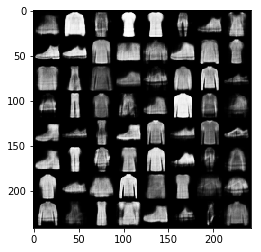

In [77]:
img_vae_random = mpimg.imread('./samples/x_vae_random.png')
plt.imshow(img_vae_random)

Choose <i>two</i> decoded entries of the previous image using the following <i>indexing</i> of an <i>entry</i> (note, that the index is computed <i>row-wise</i>):

\begin{equation}
    e_{i} = j_{row} \cdot{} d_{row} + j_{column}
\end{equation}

Whereas the single parts refer to:

- $e_{i}$ corresponds to the <i>i-th</i> entry.
- $d_{row}$ defines the amount of <i>entries</i> per row.
- $j_{row}$ specifies the <i>row</i> index (zero-based).
- $j_{column}$ specifies the <i>column</i> index (zero-based).

Plot both <i>chosen</i> entries using this notation to verify the <i>correct</i> indexing of your choices.

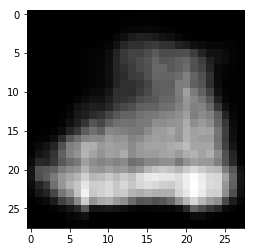

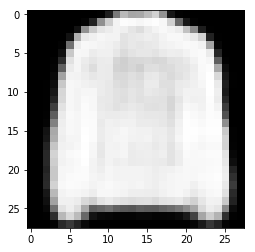

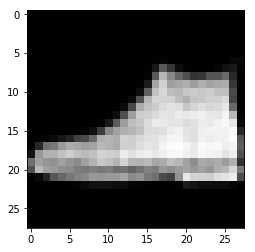

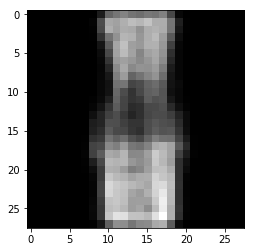

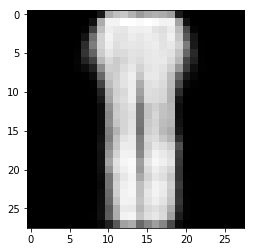

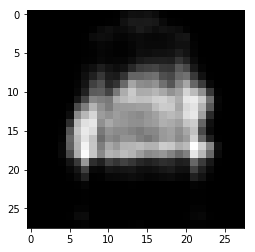

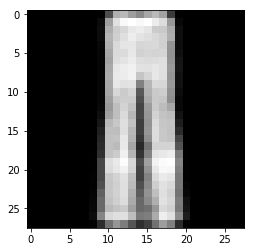

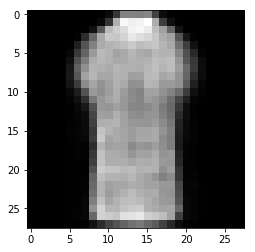

In [78]:
# different examples
example1 = 0*8+0
example2 = 0*8+1

example3 = 1*8+0 # similar to example1
example4 = 4*8+2 # similar to example2

u6.plot_example(output, example1)
u6.plot_example(output, example2)

# different examples
example5 = 5*8+1
example6 = 3*8+0

example7 = 3*8+1 # similar to example5
example8 = 1*8+7 # (more or less) similar to example6

u6.plot_example(output, example3)
u6.plot_example(output, example4)
u6.plot_example(output, example5)
u6.plot_example(output, example6)
u6.plot_example(output, example7)
u6.plot_example(output, example8)

Now comes the fun part: the actual <i>walk</i> in the <i>latent space</i>. For this very purpose, the following steps are required:

- Walk in the latent space using the <code>walk_in_latent_space</code> method of <code>u6_utils.py</code> (save the result in <code>x_vae_walk.png</code>).
- Read and <i>display</i> the just created file (keep in mind, that the result of the previous step is saved in the <code>samples</code> subdirectory).

Experiment with different <i>entries</i>, which are $\ldots$

- $\ldots$ <i>similar</i> to each other.
- $\ldots$ <i>different</i> to each other.

Try to comment on the <i>transition</i> phase. Are some targets <i>more</i> suited to be transitioned into each other than others? Try to argue about <i>possible</i> reasons.

In [79]:
u6.walk_in_latent_space(model_vae, sample_random, example1, example2, args.batch_size, hidden_dim_0, device, "x_vae_walk.png")

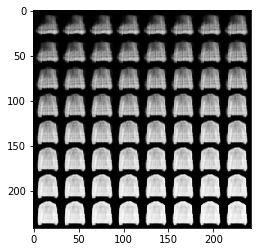

In [80]:
img_vae_walk = mpimg.imread('./samples/x_vae_walk.png')
plt.imshow(img_vae_walk)

## Answer
Shoes and sweaters are not that well suited to be transistioned into each other, because the images in the transition phase seem to be relatively meaningless.

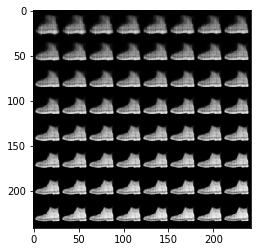

In [81]:
# shoe and shoe, similar
u6.walk_in_latent_space(model_vae, sample_random, example1, example3, args.batch_size, hidden_dim_0, device, "x_vae_walk.png")
img_vae_walk = mpimg.imread('./samples/x_vae_walk.png')
plt.imshow(img_vae_walk)

## Answer
Shoes and shoes seem to be more or less well suited to be transitioned into "each other", because during the transistion phase, some "new" shoes are occuring.

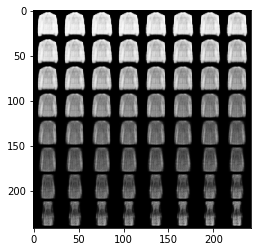

In [82]:
# sweater and dress, similar
u6.walk_in_latent_space(model_vae, sample_random, example2, example4, args.batch_size, hidden_dim_0, device, "x_vae_walk.png")
img_vae_walk = mpimg.imread('./samples/x_vae_walk.png')
plt.imshow(img_vae_walk)

## Answer
Sweaters and dresses seem to be well suited to be transistioned into each other. During the transistion phase some interesting fasion items are occuring.

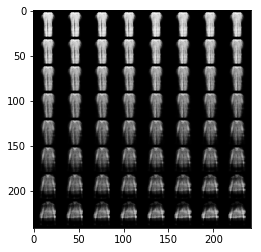

In [83]:
# pants and bag, different
u6.walk_in_latent_space(model_vae, sample_random, example5, example6, args.batch_size, hidden_dim_0, device, "x_vae_walk.png")
img_vae_walk = mpimg.imread('./samples/x_vae_walk.png')
plt.imshow(img_vae_walk)

## Answer
Pants and bags don't seem to be fitted to be transformed into each other. The images which are occuring during the transistion phase don't seem to be very meaningful. Maybe, with much imagination, one could see a dress in the images of the transistion phase here or there.

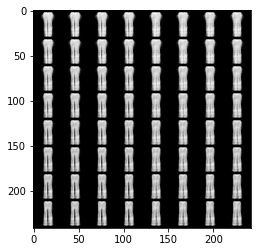

In [84]:
# pants and pants, similar
u6.walk_in_latent_space(model_vae, sample_random, example5, example7, args.batch_size, hidden_dim_0, device, "x_vae_walk.png")
img_vae_walk = mpimg.imread('./samples/x_vae_walk.png')
plt.imshow(img_vae_walk)

## Answer
Here, the same as with shoes and shoes hold: Pants and pants seem to be more or less well suited to be transitioned into "each other", because during the transistion phase, some "new" pants are occuring.

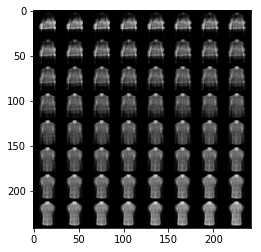

In [85]:
# bag and shirt, (more or less) similar
u6.walk_in_latent_space(model_vae, sample_random, example6, example8, args.batch_size, hidden_dim_0, device, "x_vae_walk.png")
img_vae_walk = mpimg.imread('./samples/x_vae_walk.png')
plt.imshow(img_vae_walk)

## Answer
Bags and shirt, even though they look something like a little bit similar, are not very well suited to be transitioned into each other.

# Over-all-answer
Over all, images with similar targets are better suited to be transformed into each other than very different-looking images. Reason for this is that when transistioning images with similar targets into each other, during the transistion phase here or there meaningful, <b>new</b> images are occuring whereas this is not the case with images with very different targets.